**Name: Nidhi Rajkumar Saini**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
def standardize(df):
    scaler = StandardScaler()
    std_df = scaler.fit_transform(df)
    std_df = pd.DataFrame(data = std_df, columns = df.columns)
    return std_df

In [3]:
def PCR_CV(xtrain, ytrain, fold, components):
    validation_error = 0
    #define cross validation method
    cv = KFold(n_splits = fold, shuffle = True)
    for train_idx, validation_idx in cv.split(xtrain):
        # split train and validation set
        cur_trainX = standardize(xtrain.iloc[train_idx, :])
        cur_trainY = ytrain.iloc[train_idx]
        cur_validationX = standardize(xtrain.iloc[validation_idx, :])
        cur_validationY = ytrain.iloc[validation_idx]
        # perform PCA
        pca = PCA(n_components = components).fit(cur_trainX)
        pca_train = pca.transform(cur_trainX)
        pca_validation = pca.transform(cur_validationX)
        # ordinary least squares regression using data after PCA
        regr = LinearRegression()
        regr.fit(pca_train, cur_trainY)
        predictedValidation = regr.predict(pca_validation)
        validation_mse = mean_squared_error(cur_validationY, predictedValidation)
        validation_error += validation_mse
    return validation_error / fold

In [4]:
def compute_metrics(y, predictions):
    conf_matrix = confusion_matrix(y, predictions)
    print("Confusion Matrix:\n", conf_matrix)
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    misclf = fp + fn
    print("Misclassification =", misclf)
    
    fpr, tpr, thresholds = roc_curve(y, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
lasso_MSEvals = pd.DataFrame(columns = ['Test MSE'])
models_MSE = pd.DataFrame(columns = ['Train MSE', 'Test MSE'])
fold = 5
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]

# The LASSO and Boosting for Regression

## Load the Communities and Crime data.

In [6]:
# parse the communities_names.txt file to find attribute names
attributes_file = '../data/communities_names.txt'
attributes = []
with open(attributes_file, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if (line.startswith('@attribute')):
            attributes.append(line.split(" ")[1])
# 128 attibutes expected: 122 predictive, 5 non-predictive and 1 goal
print("Total attributes:", len(attributes))
print("Goal:", attributes[-1:])

Total attributes: 128
Goal: ['ViolentCrimesPerPop']


In [7]:
df = pd.read_csv('../data/communities.csv', header = None, names = attributes, na_values='?')
df

state  county  community        communityname  fold  population  \
0         8     NaN        NaN         Lakewoodcity     1        0.19   
1        53     NaN        NaN          Tukwilacity     1        0.00   
2        24     NaN        NaN         Aberdeentown     1        0.00   
3        34     5.0    81440.0  Willingborotownship     1        0.04   
4        42    95.0     6096.0    Bethlehemtownship     1        0.01   
...     ...     ...        ...                  ...   ...         ...   
1989     12     NaN        NaN    TempleTerracecity    10        0.01   
1990      6     NaN        NaN          Seasidecity    10        0.05   
1991      9     9.0    80070.0        Waterburytown    10        0.16   
1992     25    17.0    72600.0          Walthamcity    10        0.08   
1993      6     NaN        NaN          Ontariocity    10        0.20   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0              0.33          0.02          0.90          0.12  ...      0.12   
1              0.16          0.12          0.74          0.45  ...      0.02   
2              0.42          0.49          0.56          0.17  ...      0.01   
3              0.77          1.00          0.08          0.12  ...      0.02   
4              0.55          0.02          0.95          0.09  ...      0.04   
...             ...           ...           ...           ...  ...       ...   
1989           0.40          0.10          0.87          0.12  ...      0.01   
1990           0.96          0.46          0.28          0.83  ...      0.02   
1991           0.37          0.25          0.69          0.04  ...      0.08   
1992           0.51          0.06          0.87          0.22  ...      0.03   
1993           0.78          0.14          0.46          0.24  ...      0.11   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0        0.26            0.20       0.06           0.04                 0.90   
1        0.12            0.45        NaN            NaN                  NaN   
2        0.21            0.02        NaN            NaN                  NaN   
3        0.39            0.28        NaN            NaN                  NaN   
4        0.09            0.02        NaN            NaN                  NaN   
...       ...             ...        ...            ...                  ...   
1989     0.28            0.05        NaN            NaN                  NaN   
1990     0.37            0.20        NaN            NaN                  NaN   
1991     0.32            0.18       0.08           0.06                 0.78   
1992     0.38            0.33       0.02           0.02                 0.79   
1993     0.30            0.05       0.08           0.04                 0.73   

      LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
0                     0.5                 0.32             0.14   
1                     NaN                 0.00              NaN   
2                     NaN                 0.00              NaN   
3                     NaN                 0.00              NaN   
4                     NaN                 0.00              NaN   
...                   ...                  ...              ...   
1989                  NaN                 0.00              NaN   
1990                  NaN                 0.00              NaN   
1991                  0.0                 0.91             0.28   
1992                  0.0                 0.22             0.18   
1993                  0.5                 1.00             0.13   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1989                 0.09  
1990                 0.45  
1991                 0.23  
1992                 0.19  
1993                 0.48  

[1994 rows x 128 columns]

## Data Imputation to handle Missing values

In [8]:
print("Ignoring {} non-predictive features...".format(attributes[:5]))
df = df.iloc[:, 5:]
print("Calculating the percentage of Missing values in each feature:\n")
nan_stats = df.apply(lambda col : (sum(col.isna()) / len(col))*100, axis=0)
nan_stats.loc[nan_stats != 0]

Ignoring ['state', 'county', 'community', 'communityname', 'fold'] non-predictive features...
Calculating the percentage of Missing values in each feature:



OtherPerCap              0.050150
LemasSwornFT            84.002006
LemasSwFTPerPop         84.002006
LemasSwFTFieldOps       84.002006
LemasSwFTFieldPerPop    84.002006
LemasTotalReq           84.002006
LemasTotReqPerPop       84.002006
PolicReqPerOffic        84.002006
PolicPerPop             84.002006
RacialMatchCommPol      84.002006
PctPolicWhite           84.002006
PctPolicBlack           84.002006
PctPolicHisp            84.002006
PctPolicAsian           84.002006
PctPolicMinor           84.002006
OfficAssgnDrugUnits     84.002006
NumKindsDrugsSeiz       84.002006
PolicAveOTWorked        84.002006
PolicCars               84.002006
PolicOperBudg           84.002006
LemasPctPolicOnPatr     84.002006
LemasGangUnitDeploy     84.002006
PolicBudgPerPop         84.002006
dtype: float64

As mentioned in the description of the dataset in communities_names file, a limitation was that the LEMAS survey was of the police departments with at least 100 officers, plus a random sample of smaller departments. For their purposes, communities not found in both census and crime datasets were omitted. Many communities are missing LEMAS data. It shows that there are some attributes related to LEMA survey which is only conducted in the communities with at least 100 police officers, so communities not having the least amount of officers do not have the value of that survey and cause the missing value.<br>
Thus, those values are not missed by accident but systematically. 

In [9]:
# 1 missing value in 'OtherPerCap' column
df['OtherPerCap'].iloc[130]

nan

We could observe that there are 23 attributes with missing values, most of them have large proportion of missing values (about 84%). For those with high proportion of missing values, I decide to ignore them, because using a few datapoints to assign lots of missing values won't be a good choice. It will not make sense if we still apply data imputation to these features. Rather than that, we can ignore those features where the missed ones are majority. While, for the feature with minor missing the 'OtherPerCap' attribute (only one missing value), I use mean value of that attribute to assign it.

In [10]:
print(df.isnull().values.any())
print(df.isnull().sum().sum())

True
36851


In [11]:
df['OtherPerCap'].describe()

count    1993.000000
mean        0.284742
std         0.191008
min         0.000000
25%         0.170000
50%         0.250000
75%         0.360000
max         1.000000
Name: OtherPerCap, dtype: float64

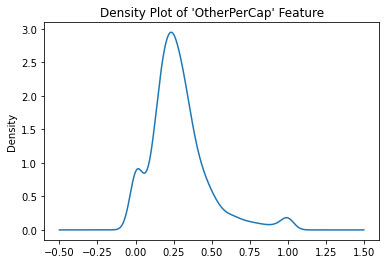

In [12]:
#drop the columns with high missing proportion > 0.3
dfnew = df.loc[:,nan_stats.values<=0.3]
pd.Series(dfnew['OtherPerCap']).plot(kind='density')
plt.title("Density Plot of 'OtherPerCap' Feature")
dfnew = dfnew.fillna(dfnew.mean())

In [13]:
# missing value imputed with mean
dfnew['OtherPerCap'].iloc[130]

0.28474159558454626

In [14]:
# after data imputation
dfnew.isnull().values.any()

False

### Split data to Train and Test.

In [15]:
trainDF = dfnew.iloc[:1495, :]
testDF = dfnew.iloc[1495:, :]
testDF.reset_index(drop=True, inplace=True)

In [16]:
trainDF

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1490        0.00           0.59          0.01          0.69          1.00   
1491        0.16           0.62          0.03          0.74          0.48   
1492        0.01           0.36          0.95          0.24          0.03   
1493        0.06           0.53          0.01          0.98          0.05   
1494        0.05           0.43          0.08          0.65          0.12   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0            0.17         0.34         0.47         0.29        0.32  ...   
1            0.07         0.26         0.59         0.35        0.27  ...   
2            0.04         0.39         0.47         0.28        0.32  ...   
3            0.10         0.51         0.50         0.34        0.21  ...   
4            0.05         0.38         0.38         0.23        0.36  ...   
...           ...          ...          ...          ...         ...  ...   
1490         0.07         0.41         0.28         0.23        0.57  ...   
1491         0.42         0.44         0.57         0.40        0.25  ...   
1492         0.01         0.44         0.42         0.27        0.63  ...   
1493         0.01         0.40         0.40         0.24        0.29  ...   
1494         1.00         0.37         0.52         0.33        0.44  ...   

      PctForeignBorn  PctBornSameState  PctSameHouse85  PctSameCity85  \
0               0.12              0.42            0.50           0.51   
1               0.21              0.50            0.34           0.60   
2               0.14              0.49            0.54           0.67   
3               0.19              0.30            0.73           0.64   
4               0.11              0.72            0.64           0.61   
...              ...               ...             ...            ...   
1490            0.61              0.46            0.75           0.72   
1491            0.60              0.44            0.39           0.68   
1492            0.02              0.86            0.61           0.77   
1493            0.08              0.78            0.63           0.70   
1494            1.00              0.16            0.63           0.71   

      PctSameState85  LandArea  PopDens  PctUsePubTrans  LemasPctOfficDrugUn  \
0               0.64      0.12     0.26            0.20                 0.32   
1               0.52      0.02     0.12            0.45                 0.00   
2               0.56      0.01     0.21            0.02                 0.00   
3               0.65      0.02     0.39            0.28                 0.00   
4               0.53      0.04     0.09            0.02                 0.00   
...              ...       ...      ...             ...                  ...   
1490            0.78      0.02     0.14            0.22                 0.00   
1491            0.67      0.07     0.40            0.14                 0.61   
1492            0.81      0.03     0.12            0.01                 0.00   
1493            0.82      0.08     0.15            0.02                 0.00   
1494            0.52      0.00     1.00            1.00                 0.51   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1490                 0.03  
1491                 0.20  
1492                 0.30  
1493                 0.03  
1494      

In [17]:
testDF

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0          0.00           0.20          0.03          0.91          0.23   
1          0.00           0.55          0.13          0.78          0.15   
2          0.00           0.52          0.04          0.59          0.05   
3          0.04           0.51          0.07          0.92          0.09   
4          0.03           0.59          0.20          0.75          0.19   
..          ...            ...           ...           ...           ...   
494        0.01           0.40          0.10          0.87          0.12   
495        0.05           0.96          0.46          0.28          0.83   
496        0.16           0.37          0.25          0.69          0.04   
497        0.08           0.51          0.06          0.87          0.22   
498        0.20           0.78          0.14          0.46          0.24   

     racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0           0.05         0.15         0.19         0.09        0.42  ...   
1           0.36         0.48         0.53         0.30        0.10  ...   
2           0.62         0.84         0.78         0.75        0.43  ...   
3           0.03         0.38         0.47         0.27        0.35  ...   
4           0.10         0.38         0.62         0.35        0.11  ...   
..           ...          ...          ...          ...         ...  ...   
494         0.16         0.43         0.51         0.35        0.30  ...   
495         0.32         0.69         0.86         0.73        0.14  ...   
496         0.25         0.35         0.50         0.31        0.54  ...   
497         0.10         0.58         0.74         0.63        0.41  ...   
498         0.77         0.50         0.62         0.40        0.17  ...   

     PctForeignBorn  PctBornSameState  PctSameHouse85  PctSameCity85  \
0              0.33              0.45            0.57           0.56   
1              0.17              0.45            0.52           0.59   
2              0.19              0.47            0.37           0.38   
3              0.10              0.62            0.70           0.75   
4              0.22              0.33            0.16           0.06   
..              ...               ...             ...            ...   
494            0.22              0.28            0.34           0.48   
495            0.53              0.25            0.17           0.10   
496            0.25              0.68            0.61           0.79   
497            0.45              0.64            0.54           0.59   
498            0.68              0.50            0.34           0.35   

     PctSameState85  LandArea  PopDens  PctUsePubTrans  LemasPctOfficDrugUn  \
0              0.74      0.01     0.23            0.73                 0.00   
1              0.57      0.01     0.18            0.02                 0.00   
2              0.49      0.01     0.18            0.00                 0.00   
3              0.64      0.06     0.13            0.16                 0.00   
4              0.27      0.03     0.23            0.06                 0.00   
..              ...       ...      ...             ...                  ...   
494            0.39      0.01     0.28            0.05                 0.00   
495            0.00      0.02     0.37            0.20                 0.00   
496            0.76      0.08     0.32            0.18                 0.91   
497            0.52      0.03     0.38            0.33                 0.22   
498            0.68      0.11     0.30            0.05                 1.00   

     ViolentCrimesPerPop  
0                   0.12  
1                   0.11  
2                   0.12  
3                   0.06  
4                   0.12  
..                   ...  
494                 0.09  
495                 0.45  
496                 0.23  
497                 0.19  
498                 0.48  

[499 rows x 101 columns]

## Plot a correlation matrix for the features in the data set.

In [18]:
xtrainDF = trainDF.iloc[: , :-1]

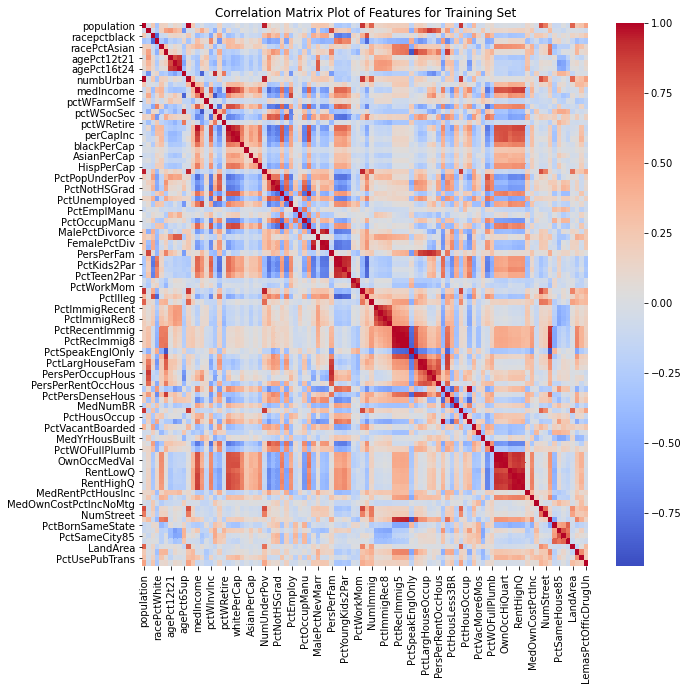

In [19]:
# plot correlation matrix for the features in the training set
fit, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(xtrainDF.corr(), cmap='coolwarm', ax=axes) 
plt.title("Correlation Matrix Plot of Features for Training Set")
plt.show()

## Calculate the Coefficient of Variation CV for each feature.

In [20]:
features = xtrainDF.columns
cv = lambda x: np.std(x) / np.mean(x)
cv_list = xtrainDF.apply(cv, axis=0).tolist()
features_cv = list(zip(features, cv_list))
# for key,value in enumerate(features_cv):
#     print("{}: {}".format(key, value))
sorted_features_cv = sorted(features_cv, key = lambda x: -x[1])
sorted_features_cv

[('NumStreet', 4.291486989120427),
 ('NumInShelters', 3.469791091959164),
 ('NumIlleg', 3.0579411110718238),
 ('NumImmig', 2.9256562747791404),
 ('LemasPctOfficDrugUn', 2.552091540968869),
 ('NumUnderPov', 2.341659559375282),
 ('population', 2.2403549658791597),
 ('numbUrban', 2.0377796181745684),
 ('HousVacant', 1.967808588822629),
 ('LandArea', 1.6448574645279186),
 ('racePctHisp', 1.6115517541662496),
 ('PctNotSpeakEnglWell', 1.4561311226776714),
 ('racepctblack', 1.4284074506092626),
 ('PctUsePubTrans', 1.3966424222596574),
 ('racePctAsian', 1.3586450597327822),
 ('PctRecentImmig', 1.2878560544980235),
 ('PctRecImmig5', 1.2857538352679252),
 ('PctRecImmig10', 1.2700511245057227),
 ('PctRecImmig8', 1.26515552090613),
 ('PctPersDenseHous', 1.1325466835532325),
 ('PctForeignBorn', 1.0655231929815296),
 ('PctVacantBoarded', 1.0544744940040391),
 ('PctHousNoPhone', 0.9224560904203152),
 ('PctIlleg', 0.9212417244387976),
 ('OwnOccMedVal', 0.8891124862678065),
 ('OwnOccHiQuart', 0.8832870

## Pick $\lfloor\sqrt{128}\rfloor$ features with highest CV, and make scatter plots and box plots for them.

In [21]:
selected = []
num_features = math.floor(math.sqrt(128))
selected_features = sorted_features_cv[:num_features]
for each in range(0,len(selected_features)):
    selected.append(selected_features[each][0])
print(selected)

['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban', 'HousVacant', 'LandArea', 'racePctHisp']


In [22]:
xtrainDF_selected = xtrainDF[selected]
xtrainDF_selected

NumStreet  NumInShelters  NumIlleg  NumImmig  LemasPctOfficDrugUn  \
0          0.00           0.04      0.04      0.03                 0.32   
1          0.00           0.00      0.00      0.01                 0.00   
2          0.00           0.00      0.01      0.00                 0.00   
3          0.00           0.00      0.03      0.02                 0.00   
4          0.00           0.00      0.00      0.00                 0.00   
...         ...            ...       ...       ...                  ...   
1490       0.00           0.00      0.00      0.01                 0.00   
1491       0.03           0.09      0.04      0.15                 0.61   
1492       0.00           0.00      0.03      0.00                 0.00   
1493       0.00           0.00      0.00      0.01                 0.00   
1494       0.00           0.00      0.04      0.15                 0.51   

      NumUnderPov  population  numbUrban  HousVacant  LandArea  racePctHisp  
0            0.08        0.19       0.20        0.21      0.12         0.17  
1            0.01        0.00       0.02        0.02      0.02         0.07  
2            0.01        0.00       0.00        0.01      0.01         0.04  
3            0.01        0.04       0.06        0.01      0.02         0.10  
4            0.00        0.01       0.02        0.01      0.04         0.05  
...           ...         ...        ...         ...       ...          ...  
1490         0.00        0.00       0.02        0.01      0.02         0.07  
1491         0.08        0.16       0.18        0.06      0.07         0.42  
1492         0.04        0.01       0.00        0.05      0.03         0.01  
1493         0.01        0.06       0.07        0.02      0.08         0.01  
1494         0.06        0.05       0.06        0.07      0.00         1.00  

[1495 rows x 11 columns]

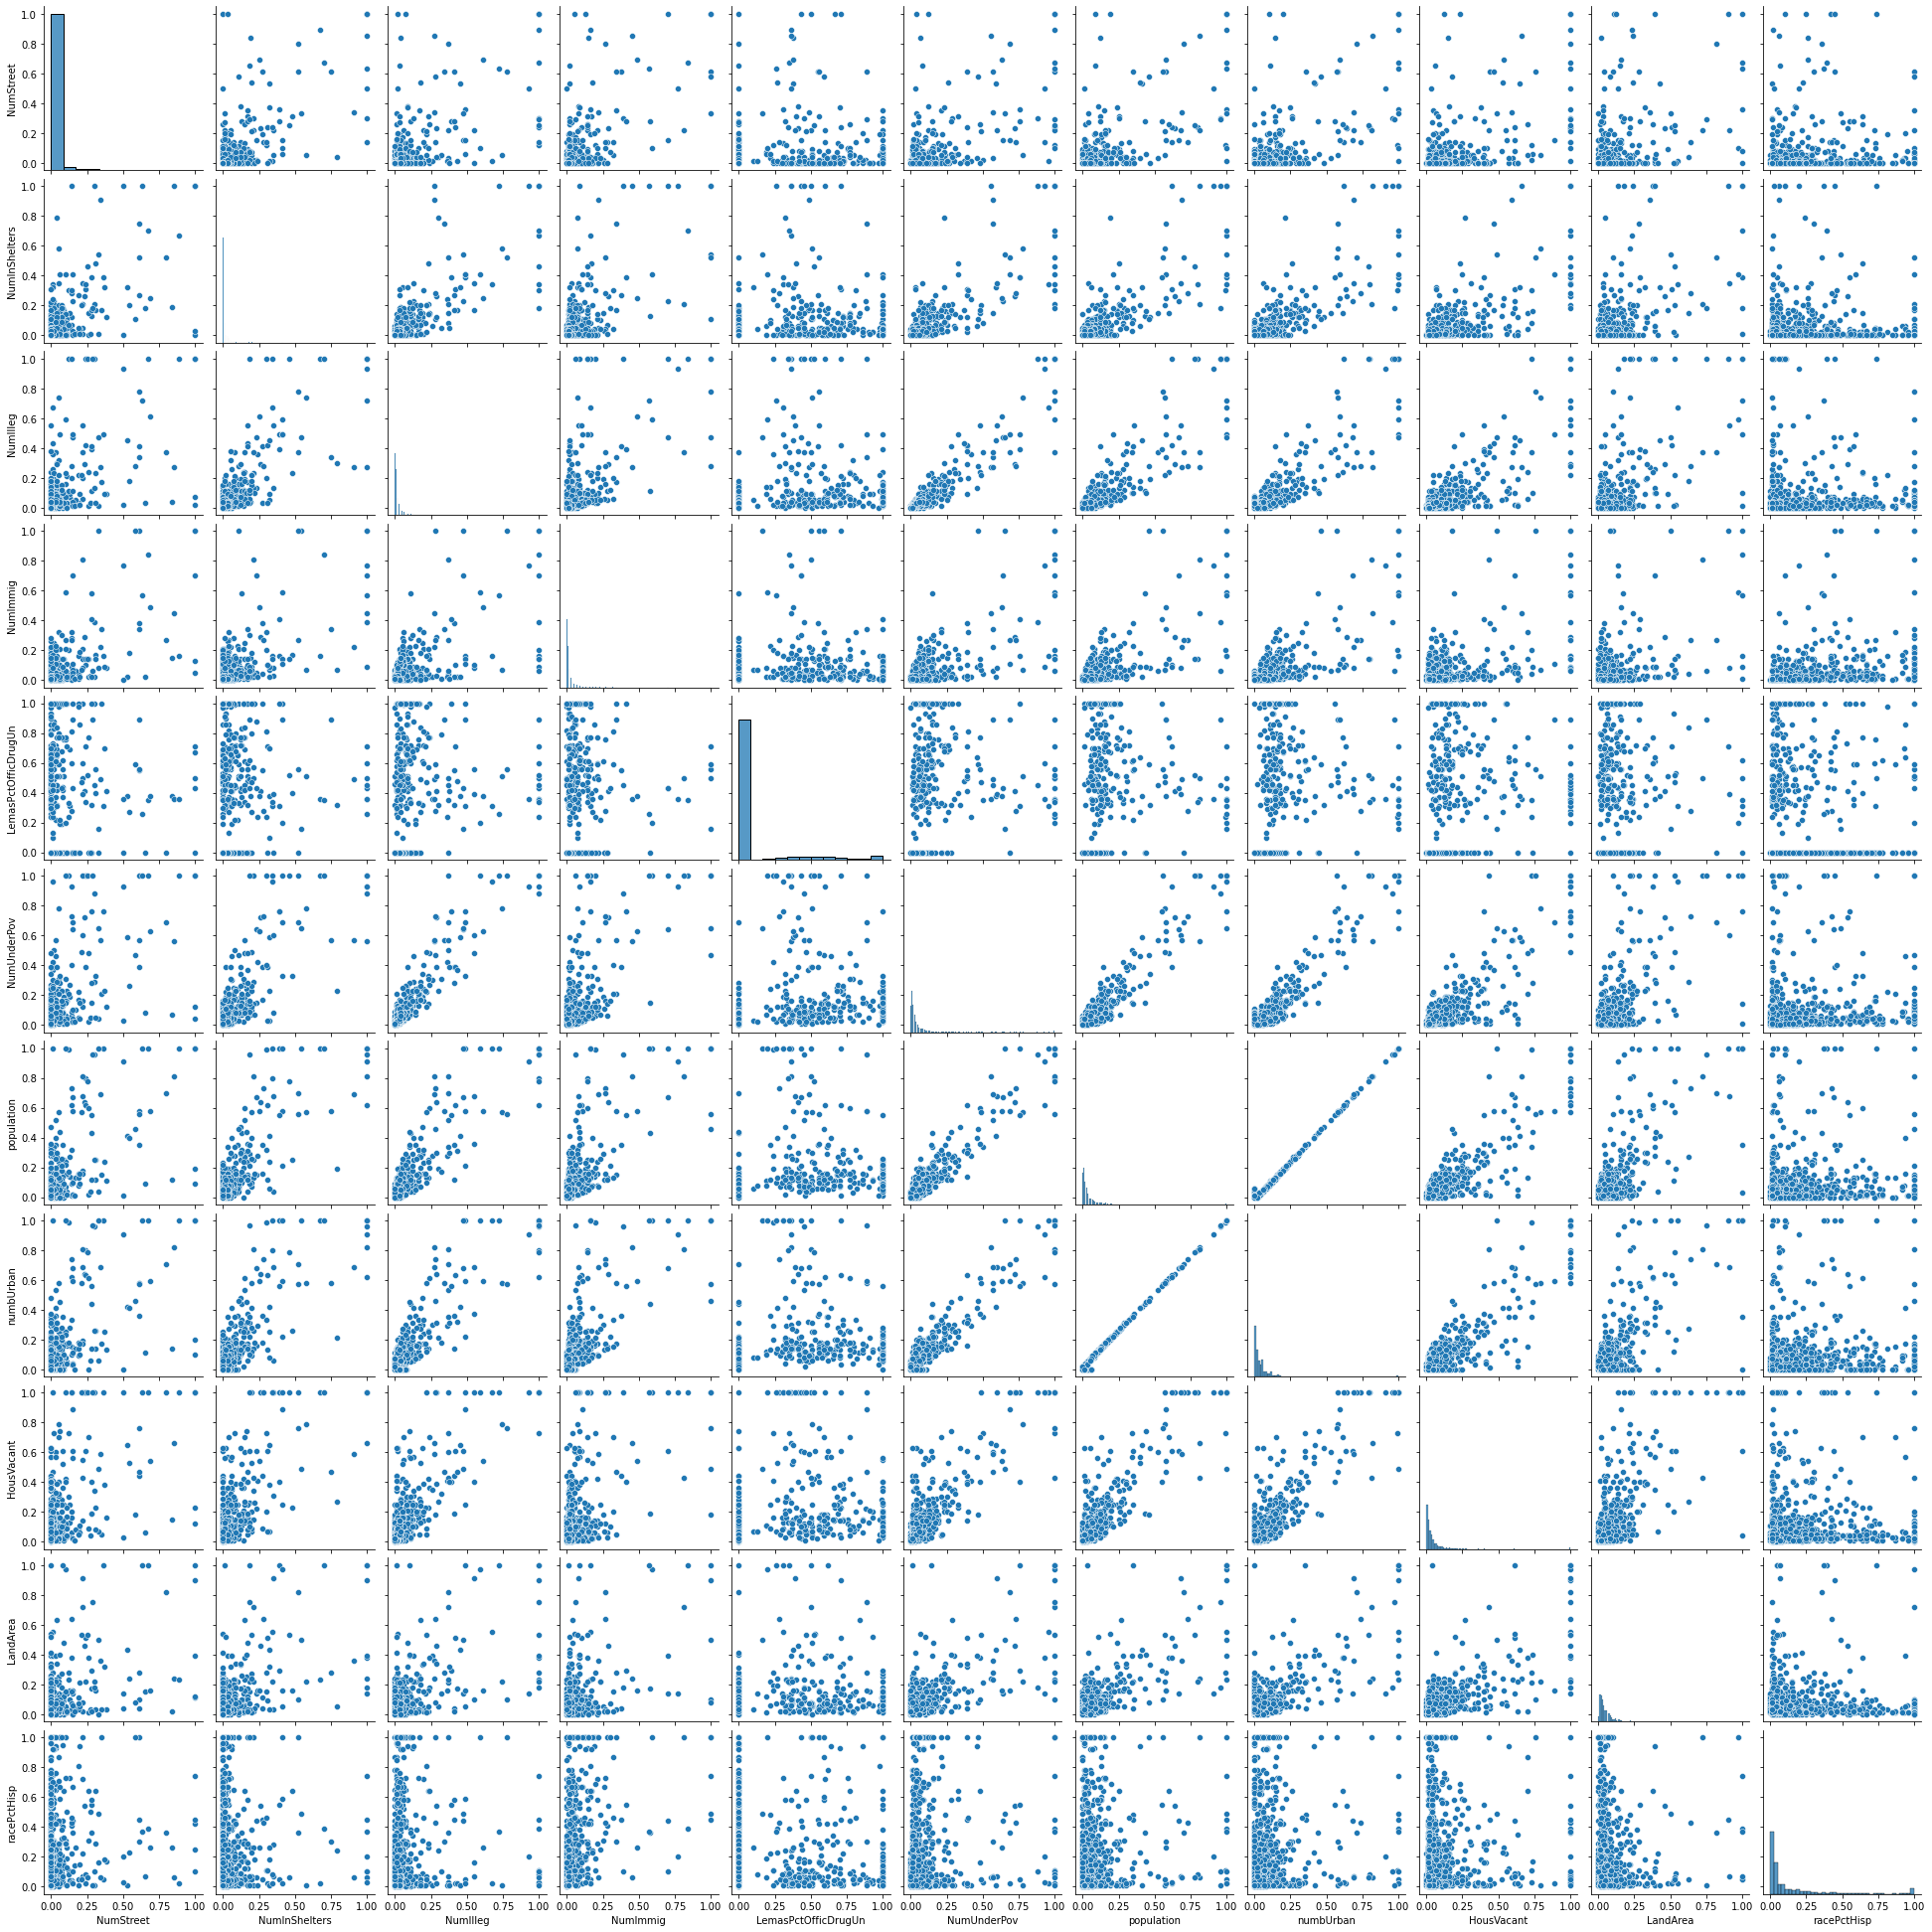

In [23]:
# scatterplot of the selected features
sns.pairplot(xtrainDF_selected)

It is hard to judge the significance of these features just by the scatterplot but by rough observation, we can see that features 'population' and 'numUrban' are highly correlated among all high CV features.

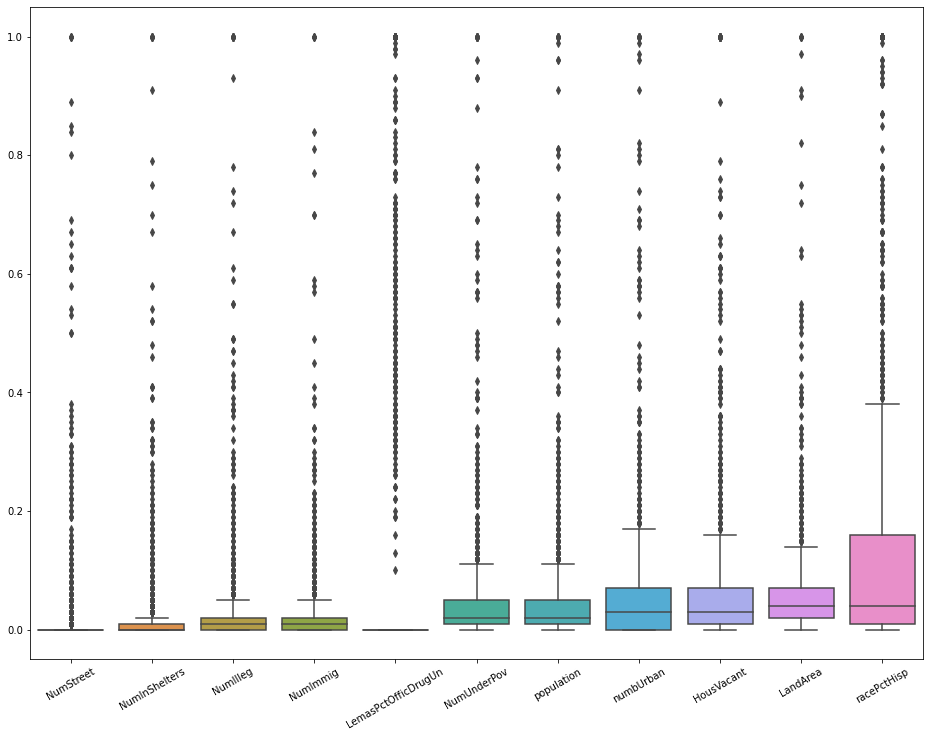

In [24]:
# boxplot of the selected features
fig, axes = plt.subplots(figsize = (16, 12))
sns.boxplot(data = xtrainDF_selected, ax = axes)
plt.xticks(rotation=30)
plt.show()

## Fit a linear model using least squares to the training set and report the test error.

In [25]:
ytrainDF = trainDF.iloc[:, -1:]
xtestDF = testDF.iloc[: , :-1]
ytestDF = testDF.iloc[:, -1:]

print("Linear model using least squares:\n")
regr = ols(formula = "ViolentCrimesPerPop ~"+ '+'.join(xtrainDF.columns), data = trainDF).fit()

trainPredict = regr.predict(xtrainDF)
trainMSE = round(mean_squared_error(ytrainDF, trainPredict), 4)
testPredict = regr.predict(xtestDF)
testMSE = round(mean_squared_error(ytestDF, testPredict), 4)
print("Train error: {}, Test error: {}\n".format(trainMSE, testMSE))

models_MSE.loc['Linear model (least squares)'] = trainMSE, testMSE

Linear model using least squares:

Train error: 0.0166, Test error: 0.0178



## Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [26]:
print("Ridge regression model with CV:\n")
ridge_regr = RidgeCV(alphas = alphas, cv = KFold(n_splits = fold, shuffle = True)).fit(xtrainDF, ytrainDF)
print("Selected λ with CV is", ridge_regr.alpha_)

trainPredict = ridge_regr.predict(xtrainDF)
trainMSE = round(mean_squared_error(ytrainDF, trainPredict), 4)
testPredict = ridge_regr.predict(xtestDF)
testMSE = round(mean_squared_error(ytestDF, testPredict), 4)
print("Train error: {}, Test error: {}\n".format(trainMSE, testMSE))

models_MSE.loc['Ridge regression model with CV'] = trainMSE, testMSE

Ridge regression model with CV:

Selected λ with CV is 1.0
Train error: 0.0169, Test error: 0.0175



## Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model.

### Lasso regression on raw features

In [27]:
print("Lasso regression model on raw features with CV:\n")

lasso_regr = LassoCV(alphas = alphas, cv = KFold(n_splits = fold, shuffle = True)).fit(xtrainDF, ytrainDF.ViolentCrimesPerPop)
print("Selected λ with CV is {}\n".format(lasso_regr.alpha_)) 

trainPredict = lasso_regr.predict(xtrainDF)
trainMSE = round(mean_squared_error(ytrainDF, trainPredict), 4)
testPredict = lasso_regr.predict(xtestDF)
lasso_testMSE = round(mean_squared_error(ytestDF, testPredict), 4)
# model_test_mse["Lasso_Regression"] = test_mse
print("Train error: {}, Test error: {}\n".format(trainMSE, lasso_testMSE))

lasso_MSEvals.loc['Lasso Regression with raw features'] = lasso_testMSE
lasso_selected_features = pd.Series(data = lasso_regr.coef_[lasso_regr.coef_!=0], index=xtestDF.columns[lasso_regr.coef_!=0])
print("{} Variables selected by the Lasso model:\n{}".format(len(lasso_selected_features),lasso_selected_features))

models_MSE.loc['Lasso regression model with CV (raw features)'] = trainMSE, lasso_testMSE

Lasso regression model on raw features with CV:

Selected λ with CV is 0.0001

Train error: 0.0171, Test error: 0.0176

67 Variables selected by the Lasso model:
racepctblack           0.275387
racePctAsian          -0.014810
agePct12t21            0.078213
agePct12t29           -0.279285
agePct65up             0.011939
                         ...   
PctSameCity85          0.028100
LandArea               0.016662
PopDens                0.007536
PctUsePubTrans        -0.046075
LemasPctOfficDrugUn    0.009125
Length: 67, dtype: float64


### Lasso regression on standardized features

In [28]:
print("Lasso regression model on standardized features with CV:\n")

std_xtrainDF = standardize(xtrainDF)
std_xtestDF = standardize(xtestDF)

lasso_regr = LassoCV(alphas = alphas, cv = KFold(n_splits = fold, shuffle = True)).fit(std_xtrainDF, ytrainDF.ViolentCrimesPerPop)
print("Selected λ with CV is {}\n".format(lasso_regr.alpha_)) 

trainPredict = lasso_regr.predict(std_xtrainDF)
trainMSE = round(mean_squared_error(ytrainDF, trainPredict), 4)
testPredict = lasso_regr.predict(std_xtestDF)
lasso_std_testMSE = round(mean_squared_error(ytestDF, testPredict), 4)
# model_test_mse["Lasso_Regression"] = test_mse

print("Train error: {}, Test error: {}\n".format(trainMSE, lasso_std_testMSE))
lasso_MSEvals.loc['Lasso Regression with standardized features'] = lasso_std_testMSE

lasso_selected_features = pd.Series(data = lasso_regr.coef_[lasso_regr.coef_!=0], index = xtestDF.columns[lasso_regr.coef_!=0])
print("{} Variables selected by the Lasso model:\n{}".format(len(lasso_selected_features),lasso_selected_features))

models_MSE.loc['Lasso regression model with CV (standardized features)'] = trainMSE, lasso_std_testMSE

Lasso regression model on standardized features with CV:

Selected λ with CV is 0.001

Train error: 0.0175, Test error: 0.0177

55 Variables selected by the Lasso model:
population              -0.001318
racepctblack             0.067537
agePct12t21              0.005808
agePct12t29             -0.027356
pctUrban                 0.015397
pctWWage                -0.009828
pctWFarmSelf             0.003414
pctWInvInc              -0.015813
pctWSocSec               0.005282
pctWPubAsst              0.003295
pctWRetire              -0.014889
whitePerCap             -0.004651
blackPerCap             -0.003123
indianPerCap            -0.005016
AsianPerCap              0.004814
OtherPerCap              0.003792
HispPerCap               0.002939
PctPopUnderPov          -0.021052
PctLess9thGrade         -0.000525
PctEmploy                0.015509
MalePctDivorce           0.016556
MalePctNevMarr           0.015150
FemalePctDiv            -0.001859
PctKids2Par             -0.041631
PctYoungKids2P

### Report the test errors for both cases and compare them.

In [29]:
lasso_MSEvals

Test MSE
Lasso Regression with raw features             0.0176
Lasso Regression with standardized features    0.0177

On comparing the Test errors, we observe that there is not much difference in the performance of the model of Lasso regression on raw features and standardized features. The test MSEs of both models are almost similar. Hence, in this case Lasso performs same with and without standarized features.

## Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [30]:
avg_validation_errors = []
for M in range(1, len(xtrainDF.columns) + 1):
    validation_error = PCR_CV(xtrainDF, ytrainDF, 5, M)
    avg_validation_errors.append((M, validation_error))

# sort the list and get the minimum validation error to get best M
avg_validation_errors.sort(key=lambda x: x[1])
bestM = avg_validation_errors[0][0]
print("When M = {}, the validation MSE reaches minimum of {}.".format(bestM, round(avg_validation_errors[0][1], 4)))

When M = 89, the validation MSE reaches minimum of 0.0191.


In [31]:
print("PCR model:\n")

# standardize data before PCA
std_xtrainDF = standardize(xtrainDF)
std_xtestDF = standardize(xtestDF)

# create a PCA model using best M
pca = PCA(n_components = bestM).fit(std_xtrainDF)

# apply PCA to train and test set
pca_train = pca.transform(std_xtrainDF)
pca_test = pca.transform(std_xtestDF)

# linear regression with PCA results
regr = LinearRegression().fit(pca_train, ytrainDF)
train_pred = regr.predict(pca_train)
pcr_train_mse = round(mean_squared_error(ytrainDF, train_pred), 4)
test_pred = regr.predict(pca_test)
pcr_test_mse = round(mean_squared_error(ytestDF, test_pred), 4)
# model_test_mse["PCR"] = test_mse
print("Train error: {}, Test error: {}\n".format(pcr_train_mse, pcr_test_mse))

models_MSE.loc['PCR model with CV'] = pcr_train_mse, pcr_test_mse

PCR model:

Train error: 0.0167, Test error: 0.018



##  Fit a boosting tree to the data (XGBoost). Determine α (the regularization term) using cross-validation.

In [32]:
# L1 penalized gradient boosting tree
data_dmatrix = xgb.DMatrix(data = xtrainDF, label = ytrainDF)
xgbcv_rmse = pd.DataFrame(columns = ['CVrmse'])
for alpha in alphas:
    params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.3, 'max_depth': 5, 'alpha': alpha}
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold = 5, num_boost_round = 50, early_stopping_rounds = 10, metrics="rmse", as_pandas=True, seed=123)
    xgbcv_rmse.loc[str(alpha),:] = ((cv_results["test-rmse-mean"]).tail(1)).values

bestalpha = int(xgbcv_rmse.index[xgbcv_rmse.CVrmse == min(xgbcv_rmse.CVrmse)][0])
print("Best alpha: {} with min RMSE: {}".format(bestalpha,min(xgbcv_rmse.CVrmse)))

Best alpha: 1 with min RMSE: 0.1444262


In [33]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.3, 'max_depth': 5, 'alpha': bestalpha}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold = 5, num_boost_round = 50, early_stopping_rounds = 10, metrics="rmse", as_pandas=True, seed=123)
num_round = cv_results.shape[0]
print("Number of rounds:",num_round)

Number of rounds: 30


In [34]:
xg_reg = xgb.train(params = params, dtrain = data_dmatrix, num_boost_round = num_round)
trainPredict = xg_reg.predict(data_dmatrix)
xgtrain_mse = round(mean_squared_error(ytrainDF, trainPredict), 4)

test_dmatrix = xgb.DMatrix(data = xtestDF)
testPredict = xg_reg.predict(test_dmatrix)
xgtest_mse = round(mean_squared_error(ytestDF, testPredict), 4)

print("XGBoost model:\n")
print("Train error: {}, Test error: {}\n".format(xgtrain_mse, xgtest_mse))

models_MSE.loc['XGBoost model with CV'] = xgtrain_mse, xgtest_mse

XGBoost model:

Train error: 0.0053, Test error: 0.0174



## Summary

In [35]:
models_MSE

Train MSE  Test MSE
Linear model (least squares)                           0.0166    0.0178
Ridge regression model with CV                         0.0169    0.0175
Lasso regression model with CV (raw features)          0.0171    0.0176
Lasso regression model with CV (standardized fe...     0.0175    0.0177
PCR model with CV                                      0.0167    0.0180
XGBoost model with CV                                  0.0053    0.0174

# Tree-Based Methods

## Load the APS Failure data

In [36]:
aps_traindf = pd.read_csv('../data/aps_failure_training_set.csv', na_values='na', skiprows = 20)
aps_traindf

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0       neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0   
1       neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0   
2       neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0   
3       neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0   
4       neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0   
...     ...     ...     ...           ...     ...     ...     ...     ...   
59995   neg  153002     NaN  6.640000e+02   186.0     0.0     0.0     0.0   
59996   neg    2286     NaN  2.130707e+09   224.0     0.0     0.0     0.0   
59997   neg     112     0.0  2.130706e+09    18.0     0.0     0.0     0.0   
59998   neg   80292     NaN  2.130706e+09   494.0     0.0     0.0     0.0   
59999   neg   40222     NaN  6.980000e+02   628.0     0.0     0.0     0.0   

       ag_001  ag_002  ...     ee_002    ee_003     ee_004     ee_005  \
0         0.0     0.0  ...  1240520.0  493384.0   721044.0   469792.0   
1         0.0     0.0  ...   421400.0  178064.0   293306.0   245416.0   
2         0.0     0.0  ...   277378.0  159812.0   423992.0   409564.0   
3         0.0     0.0  ...      240.0      46.0       58.0       44.0   
4         0.0     0.0  ...   622012.0  229790.0   405298.0   347188.0   
...       ...     ...  ...        ...       ...        ...        ...   
59995     0.0     0.0  ...   998500.0  566884.0  1290398.0  1218244.0   
59996     0.0     0.0  ...    10578.0    6760.0    21126.0    68424.0   
59997     0.0     0.0  ...      792.0     386.0      452.0      144.0   
59998     0.0     0.0  ...   699352.0  222654.0   347378.0   225724.0   
59999     0.0     0.0  ...   440066.0  183200.0   344546.0   254068.0   

          ee_006    ee_007    ee_008    ee_009  ef_000  eg_000  
0       339156.0  157956.0   73224.0       0.0     0.0     0.0  
1       133654.0   81140.0   97576.0    1500.0     0.0     0.0  
2       320746.0  158022.0   95128.0     514.0     0.0     0.0  
3           10.0       0.0       0.0       0.0     4.0    32.0  
4       286954.0  311560.0  433954.0    1218.0     0.0     0.0  
...          ...       ...       ...       ...     ...     ...  
59995  1019768.0  717762.0  898642.0   28588.0     0.0     0.0  
59996      136.0       0.0       0.0       0.0     0.0     0.0  
59997      146.0    2622.0       0.0       0.0     0.0     0.0  
59998   194440.0  165070.0  802280.0  388422.0     0.0     0.0  
59999   225148.0  158304.0  170384.0     158.0     0.0     0.0  

[60000 rows x 171 columns]

In [37]:
aps_testdf = pd.read_csv('../data/aps_failure_test_set.csv', na_values='na', skiprows = 20)
aps_testdf

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0       neg      60     0.0  2.000000e+01    12.0     0.0     0.0     0.0   
1       neg      82     0.0  6.800000e+01    40.0     0.0     0.0     0.0   
2       neg   66002     2.0  2.120000e+02   112.0     0.0     0.0     0.0   
3       neg   59816     NaN  1.010000e+03   936.0     0.0     0.0     0.0   
4       neg    1814     NaN  1.560000e+02   140.0     0.0     0.0     0.0   
...     ...     ...     ...           ...     ...     ...     ...     ...   
15995   neg   81852     NaN  2.130706e+09   892.0     0.0     0.0     0.0   
15996   neg      18     0.0  5.200000e+01    46.0     8.0    26.0     0.0   
15997   neg   79636     NaN  1.670000e+03  1518.0     0.0     0.0     0.0   
15998   neg     110     NaN  3.600000e+01    32.0     0.0     0.0     0.0   
15999   neg       8     0.0  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002  ...    ee_002    ee_003    ee_004    ee_005     ee_006  \
0         0.0     0.0  ...    1098.0     138.0     412.0     654.0       78.0   
1         0.0     0.0  ...    1068.0     276.0    1620.0     116.0       86.0   
2         0.0     0.0  ...  495076.0  380368.0  440134.0  269556.0  1315022.0   
3         0.0     0.0  ...  540820.0  243270.0  483302.0  485332.0   431376.0   
4         0.0     0.0  ...    7646.0    4144.0   18466.0   49782.0     3176.0   
...       ...     ...  ...       ...       ...       ...       ...        ...   
15995     0.0     0.0  ...  632658.0  273242.0  510354.0  373918.0   349840.0   
15996     0.0     0.0  ...     266.0      44.0      46.0      14.0        2.0   
15997     0.0     0.0  ...  806832.0  449962.0  778826.0  581558.0   375498.0   
15998     0.0     0.0  ...     588.0     210.0     180.0     544.0     1004.0   
15999     0.0     0.0  ...      46.0      10.0      48.0      14.0       42.0   

         ee_007    ee_008   ee_009  ef_000  eg_000  
0          88.0       0.0      0.0     0.0     0.0  
1         462.0       0.0      0.0     0.0     0.0  
2      153680.0     516.0      0.0     0.0     0.0  
3      210074.0  281662.0   3232.0     0.0     0.0  
4         482.0      76.0      0.0     0.0     0.0  
...         ...       ...      ...     ...     ...  
15995  317840.0  960024.0  25566.0     0.0     0.0  
15996       0.0       0.0      0.0     0.0     0.0  
15997  222866.0  358934.0  19548.0     0.0     0.0  
15998    1338.0      74.0      0.0     0.0     0.0  
15999      46.0       0.0      0.0     0.0     0.0  

[16000 rows x 171 columns]

## Data Preparation

In [38]:
aps_data = pd.concat([aps_traindf, aps_testdf], axis=0)
aps_data.reset_index(drop=True, inplace=True)
# APS_data
print("Calculating the percentage of Missing values in each feature:\n")
nan_stats = aps_data.apply(lambda col : (sum(col.isna()) / len(col))*100, axis=0)
nan_stats.loc[nan_stats != 0]

Calculating the percentage of Missing values in each feature:



ab_000    77.226316
ac_000     5.606579
ad_000    24.792105
ae_000     4.197368
af_000     4.197368
            ...    
ee_007     1.135526
ee_008     1.135526
ee_009     1.135526
ef_000     4.586842
eg_000     4.585526
Length: 169, dtype: float64

### Research what types of techniques are usually used for dealing with data with missing values.

Real-world data often has missing values.<br>
Data can have missing values for a number of reasons such as observations that were not recorded and data corruption.<br>
Handling missing data is important as many machine learning algorithms do not support data with missing values.<br>

There are multiple techniques to deal with missing values in data such as:<br>
1. Remove Rows With Missing Values<br>
The simplest approach for dealing with missing values is to remove entire predictor(s) and/or sample(s) that contain missing values.<br>
Removing rows with missing values can be too limiting on some predictive modeling problems, an alternative is to impute missing values.<br>
2. Impute Missing Values<br>
Imputing refers to using a model to replace missing values.<br>
There are many options we could consider when replacing a missing value, for example:<br>
- A constant value that has meaning within the domain, such as 0, distinct from all other values.
- A value from another randomly selected record.
- A mean, median or mode value for the column.
- A value estimated by another predictive model.<br>

One type of imputation algorithm is univariate, which imputes values in the i-th feature dimension using only non-missing values in that feature dimension (e.g. impute.SimpleImputer) with mean, median, mode, etc. By contrast, multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values (e.g. impute.IterativeImputer).

#### Pick at least one of them and apply it to this data in the next steps.

In [39]:
aps_traindf

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0       neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0   
1       neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0   
2       neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0   
3       neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0   
4       neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0   
...     ...     ...     ...           ...     ...     ...     ...     ...   
59995   neg  153002     NaN  6.640000e+02   186.0     0.0     0.0     0.0   
59996   neg    2286     NaN  2.130707e+09   224.0     0.0     0.0     0.0   
59997   neg     112     0.0  2.130706e+09    18.0     0.0     0.0     0.0   
59998   neg   80292     NaN  2.130706e+09   494.0     0.0     0.0     0.0   
59999   neg   40222     NaN  6.980000e+02   628.0     0.0     0.0     0.0   

       ag_001  ag_002  ...     ee_002    ee_003     ee_004     ee_005  \
0         0.0     0.0  ...  1240520.0  493384.0   721044.0   469792.0   
1         0.0     0.0  ...   421400.0  178064.0   293306.0   245416.0   
2         0.0     0.0  ...   277378.0  159812.0   423992.0   409564.0   
3         0.0     0.0  ...      240.0      46.0       58.0       44.0   
4         0.0     0.0  ...   622012.0  229790.0   405298.0   347188.0   
...       ...     ...  ...        ...       ...        ...        ...   
59995     0.0     0.0  ...   998500.0  566884.0  1290398.0  1218244.0   
59996     0.0     0.0  ...    10578.0    6760.0    21126.0    68424.0   
59997     0.0     0.0  ...      792.0     386.0      452.0      144.0   
59998     0.0     0.0  ...   699352.0  222654.0   347378.0   225724.0   
59999     0.0     0.0  ...   440066.0  183200.0   344546.0   254068.0   

          ee_006    ee_007    ee_008    ee_009  ef_000  eg_000  
0       339156.0  157956.0   73224.0       0.0     0.0     0.0  
1       133654.0   81140.0   97576.0    1500.0     0.0     0.0  
2       320746.0  158022.0   95128.0     514.0     0.0     0.0  
3           10.0       0.0       0.0       0.0     4.0    32.0  
4       286954.0  311560.0  433954.0    1218.0     0.0     0.0  
...          ...       ...       ...       ...     ...     ...  
59995  1019768.0  717762.0  898642.0   28588.0     0.0     0.0  
59996      136.0       0.0       0.0       0.0     0.0     0.0  
59997      146.0    2622.0       0.0       0.0     0.0     0.0  
59998   194440.0  165070.0  802280.0  388422.0     0.0     0.0  
59999   225148.0  158304.0  170384.0     158.0     0.0     0.0  

[60000 rows x 171 columns]

In [40]:
strlabels_train = aps_traindf['class']
strlabels_test = aps_testdf['class']

In [41]:
# Label encode categorical column ('class') : neg = 0 and pos = 1
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
aps_traindf['class'] = le.fit_transform(aps_traindf['class'])
aps_testdf['class'] = le.fit_transform(aps_testdf['class'])
# aps_traindf[aps_traindf['class'] == 1]

In [42]:
aps_traindf.describe()

class        aa_000        ab_000        ac_000        ad_000  \
count  60000.000000  6.000000e+04  13671.000000  5.666500e+04  4.513900e+04   
mean       0.016667  5.933650e+04      0.713189  3.560143e+08  1.906206e+05   
std        0.128020  1.454301e+05      3.478962  7.948749e+08  4.040441e+07   
min        0.000000  0.000000e+00      0.000000  0.000000e+00  0.000000e+00   
25%        0.000000  8.340000e+02      0.000000  1.600000e+01  2.400000e+01   
50%        0.000000  3.077600e+04      0.000000  1.520000e+02  1.260000e+02   
75%        0.000000  4.866800e+04      0.000000  9.640000e+02  4.300000e+02   
max        1.000000  2.746564e+06    204.000000  2.130707e+09  8.584298e+09   

             ae_000        af_000        ag_000        ag_001        ag_002  \
count  57500.000000  57500.000000  5.932900e+04  5.932900e+04  5.932900e+04   
mean       6.819130     11.006817  2.216364e+02  9.757223e+02  8.606015e+03   
std      161.543373    209.792592  2.047846e+04  3.420053e+04  1.503220e+05   
min        0.000000      0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000      0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
50%        0.000000      0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
75%        0.000000      0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
max    21050.000000  20070.000000  3.376892e+06  4.109372e+06  1.055286e+07   

       ...        ee_002        ee_003        ee_004        ee_005  \
count  ...  5.932900e+04  5.932900e+04  5.932900e+04  5.932900e+04   
mean   ...  4.454897e+05  2.111264e+05  4.457343e+05  3.939462e+05   
std    ...  1.155540e+06  5.433188e+05  1.168314e+06  1.121044e+06   
min    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    ...  2.936000e+03  1.166000e+03  2.700000e+03  3.584000e+03   
50%    ...  2.337960e+05  1.120860e+05  2.215180e+05  1.899880e+05   
75%    ...  4.383960e+05  2.182320e+05  4.666140e+05  4.032220e+05   
max    ...  7.793393e+07  3.775839e+07  9.715238e+07  5.743524e+07   

             ee_006        ee_007        ee_008        ee_009        ef_000  \
count  5.932900e+04  5.932900e+04  5.932900e+04  5.932900e+04  57276.000000   
mean   3.330582e+05  3.462714e+05  1.387300e+05  8.388915e+03      0.090579   
std    1.069160e+06  1.728056e+06  4.495100e+05  4.747043e+04      4.368855   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00      0.000000   
25%    5.120000e+02  1.100000e+02  0.000000e+00  0.000000e+00      0.000000   
50%    9.243200e+04  4.109800e+04  3.812000e+03  0.000000e+00      0.000000   
75%    2.750940e+05  1.678140e+05  1.397240e+05  2.028000e+03      0.000000   
max    3.160781e+07  1.195801e+08  1.926740e+07  3.810078e+06    482.000000   

             eg_000  
count  57277.000000  
mean       0.212756  
std        8.830641  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max     1146.000000  

[8 rows x 171 columns]

In [43]:
print(aps_traindf.isnull().values.any())
print(aps_traindf.isnull().sum().sum())

True
850015


In [44]:
print(aps_testdf.isnull().values.any())
print(aps_testdf.isnull().sum().sum())

True
228680


I select mean as the imputation technique to handle missing values in the dataset.

In [45]:
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
aps_traindf.iloc[:, 1:] = imp_mean.fit_transform(aps_traindf.iloc[:,1:])
aps_testdf.iloc[:, 1:] = imp_mean.fit_transform(aps_testdf.iloc[:,1:])

In [46]:
print(aps_traindf.isnull().values.any())
print(aps_traindf.isnull().sum().sum())

False
0


In [47]:
print(aps_testdf.isnull().values.any())
print(aps_testdf.isnull().sum().sum())

False
0


In [48]:
# split features and label
aps_trainX = aps_traindf.iloc[:, 1:]
aps_trainY = aps_traindf.iloc[:, 0]
aps_testX = aps_testdf.iloc[:, 1:]
aps_testY = aps_testdf.iloc[:, 0]

### Calculate the Coefficient of Variation CV for each feature.

In [49]:
features = aps_trainX.columns
cv = lambda x: np.std(x) / np.mean(x)
cv_list = aps_trainX.apply(cv, axis = 0).tolist()
features_cv = list(zip(features, cv_list))
sorted_features_cv = sorted(features_cv, key = lambda x: -x[1])
sorted_features_cv

[('cs_009', 235.2756439554245),
 ('cf_000', 184.23155690901163),
 ('co_000', 183.94748454109805),
 ('ad_000', 183.8460882991141),
 ('dh_000', 114.98403263787199),
 ('dj_000', 109.64637120769159),
 ('ag_000', 91.87779897147188),
 ('as_000', 86.4161836966494),
 ('ay_009', 83.78536478848595),
 ('az_009', 76.96733666109884),
 ('ak_000', 74.52606690027996),
 ('au_000', 68.15998600570832),
 ('ch_000', 58.26774309169662),
 ('ay_001', 52.233416479689936),
 ('dz_000', 49.00174974796767),
 ('df_000', 48.798608254364645),
 ('cs_008', 47.68191225312383),
 ('ef_000', 47.12456038209328),
 ('aj_000', 43.801457366011356),
 ('eg_000', 40.55291204598688),
 ('ay_002', 38.80925698740108),
 ('dl_000', 37.08336721746883),
 ('ay_000', 37.00925391275805),
 ('dg_000', 35.91411913827239),
 ('ag_001', 34.854659618594006),
 ('dk_000', 34.56433737943617),
 ('cn_009', 33.88039245543409),
 ('dm_000', 33.83733384220219),
 ('ay_004', 33.3744378808924),
 ('ea_000', 33.35960209350494),
 ('ag_009', 32.98407617059891),
 (

### Plot a correlation matrix for your features.

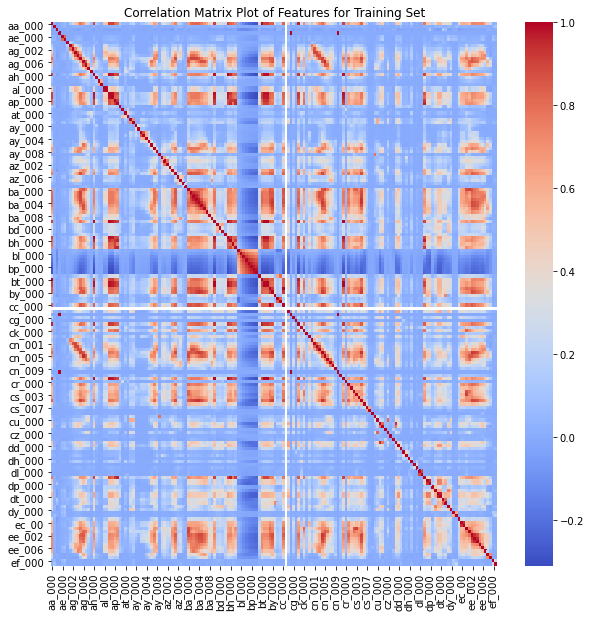

In [50]:
# plot correlation matrix for the features in the training set
fit, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(aps_trainX.corr(), cmap = 'coolwarm', ax = axes) 
plt.title("Correlation Matrix Plot of Features for Training Set")
plt.show()

### Pick $\lfloor\sqrt{170}\rfloor$ features with highest CV, and make scatter plots and box plots for them.

In [51]:
selected = []
num_features = math.floor(math.sqrt(170))
selected_features = sorted_features_cv[:num_features]
for each in range(0,len(selected_features)):
    selected.append(selected_features[each][0])
print(selected)

['cs_009', 'cf_000', 'co_000', 'ad_000', 'dh_000', 'dj_000', 'ag_000', 'as_000', 'ay_009', 'az_009', 'ak_000', 'au_000', 'ch_000']


In [52]:
aps_trainX_selected = aps_traindf[['class'] + selected]

In [53]:
aps_trainX_selected

class  cs_009         cf_000         co_000         ad_000  dh_000  \
0          0     0.0       2.000000     220.000000     280.000000     0.0   
1          0     0.0  190221.810984  190515.566938  190620.639314     0.0   
2          0     0.0       0.000000       0.000000     100.000000     0.0   
3          0     0.0       2.000000       2.000000      66.000000     0.0   
4          0     0.0       0.000000     202.000000     458.000000     0.0   
...      ...     ...            ...            ...            ...     ...   
59995      0     0.0       0.000000     224.000000     186.000000     0.0   
59996      0     0.0       2.000000       0.000000     224.000000     0.0   
59997      0     0.0       2.000000       0.000000      18.000000     0.0   
59998      0     0.0       2.000000     580.000000     494.000000   190.0   
59999      0     0.0       0.000000       6.000000     628.000000     0.0   

       dj_000  ag_000  as_000  ay_009  az_009  ak_000  au_000    ch_000  
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000000  
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000443  
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000000  
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000000  
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000000  
...       ...     ...     ...     ...     ...     ...     ...       ...  
59995     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000000  
59996     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000000  
59997     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000000  
59998     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000000  
59999     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.000000  

[60000 rows x 14 columns]

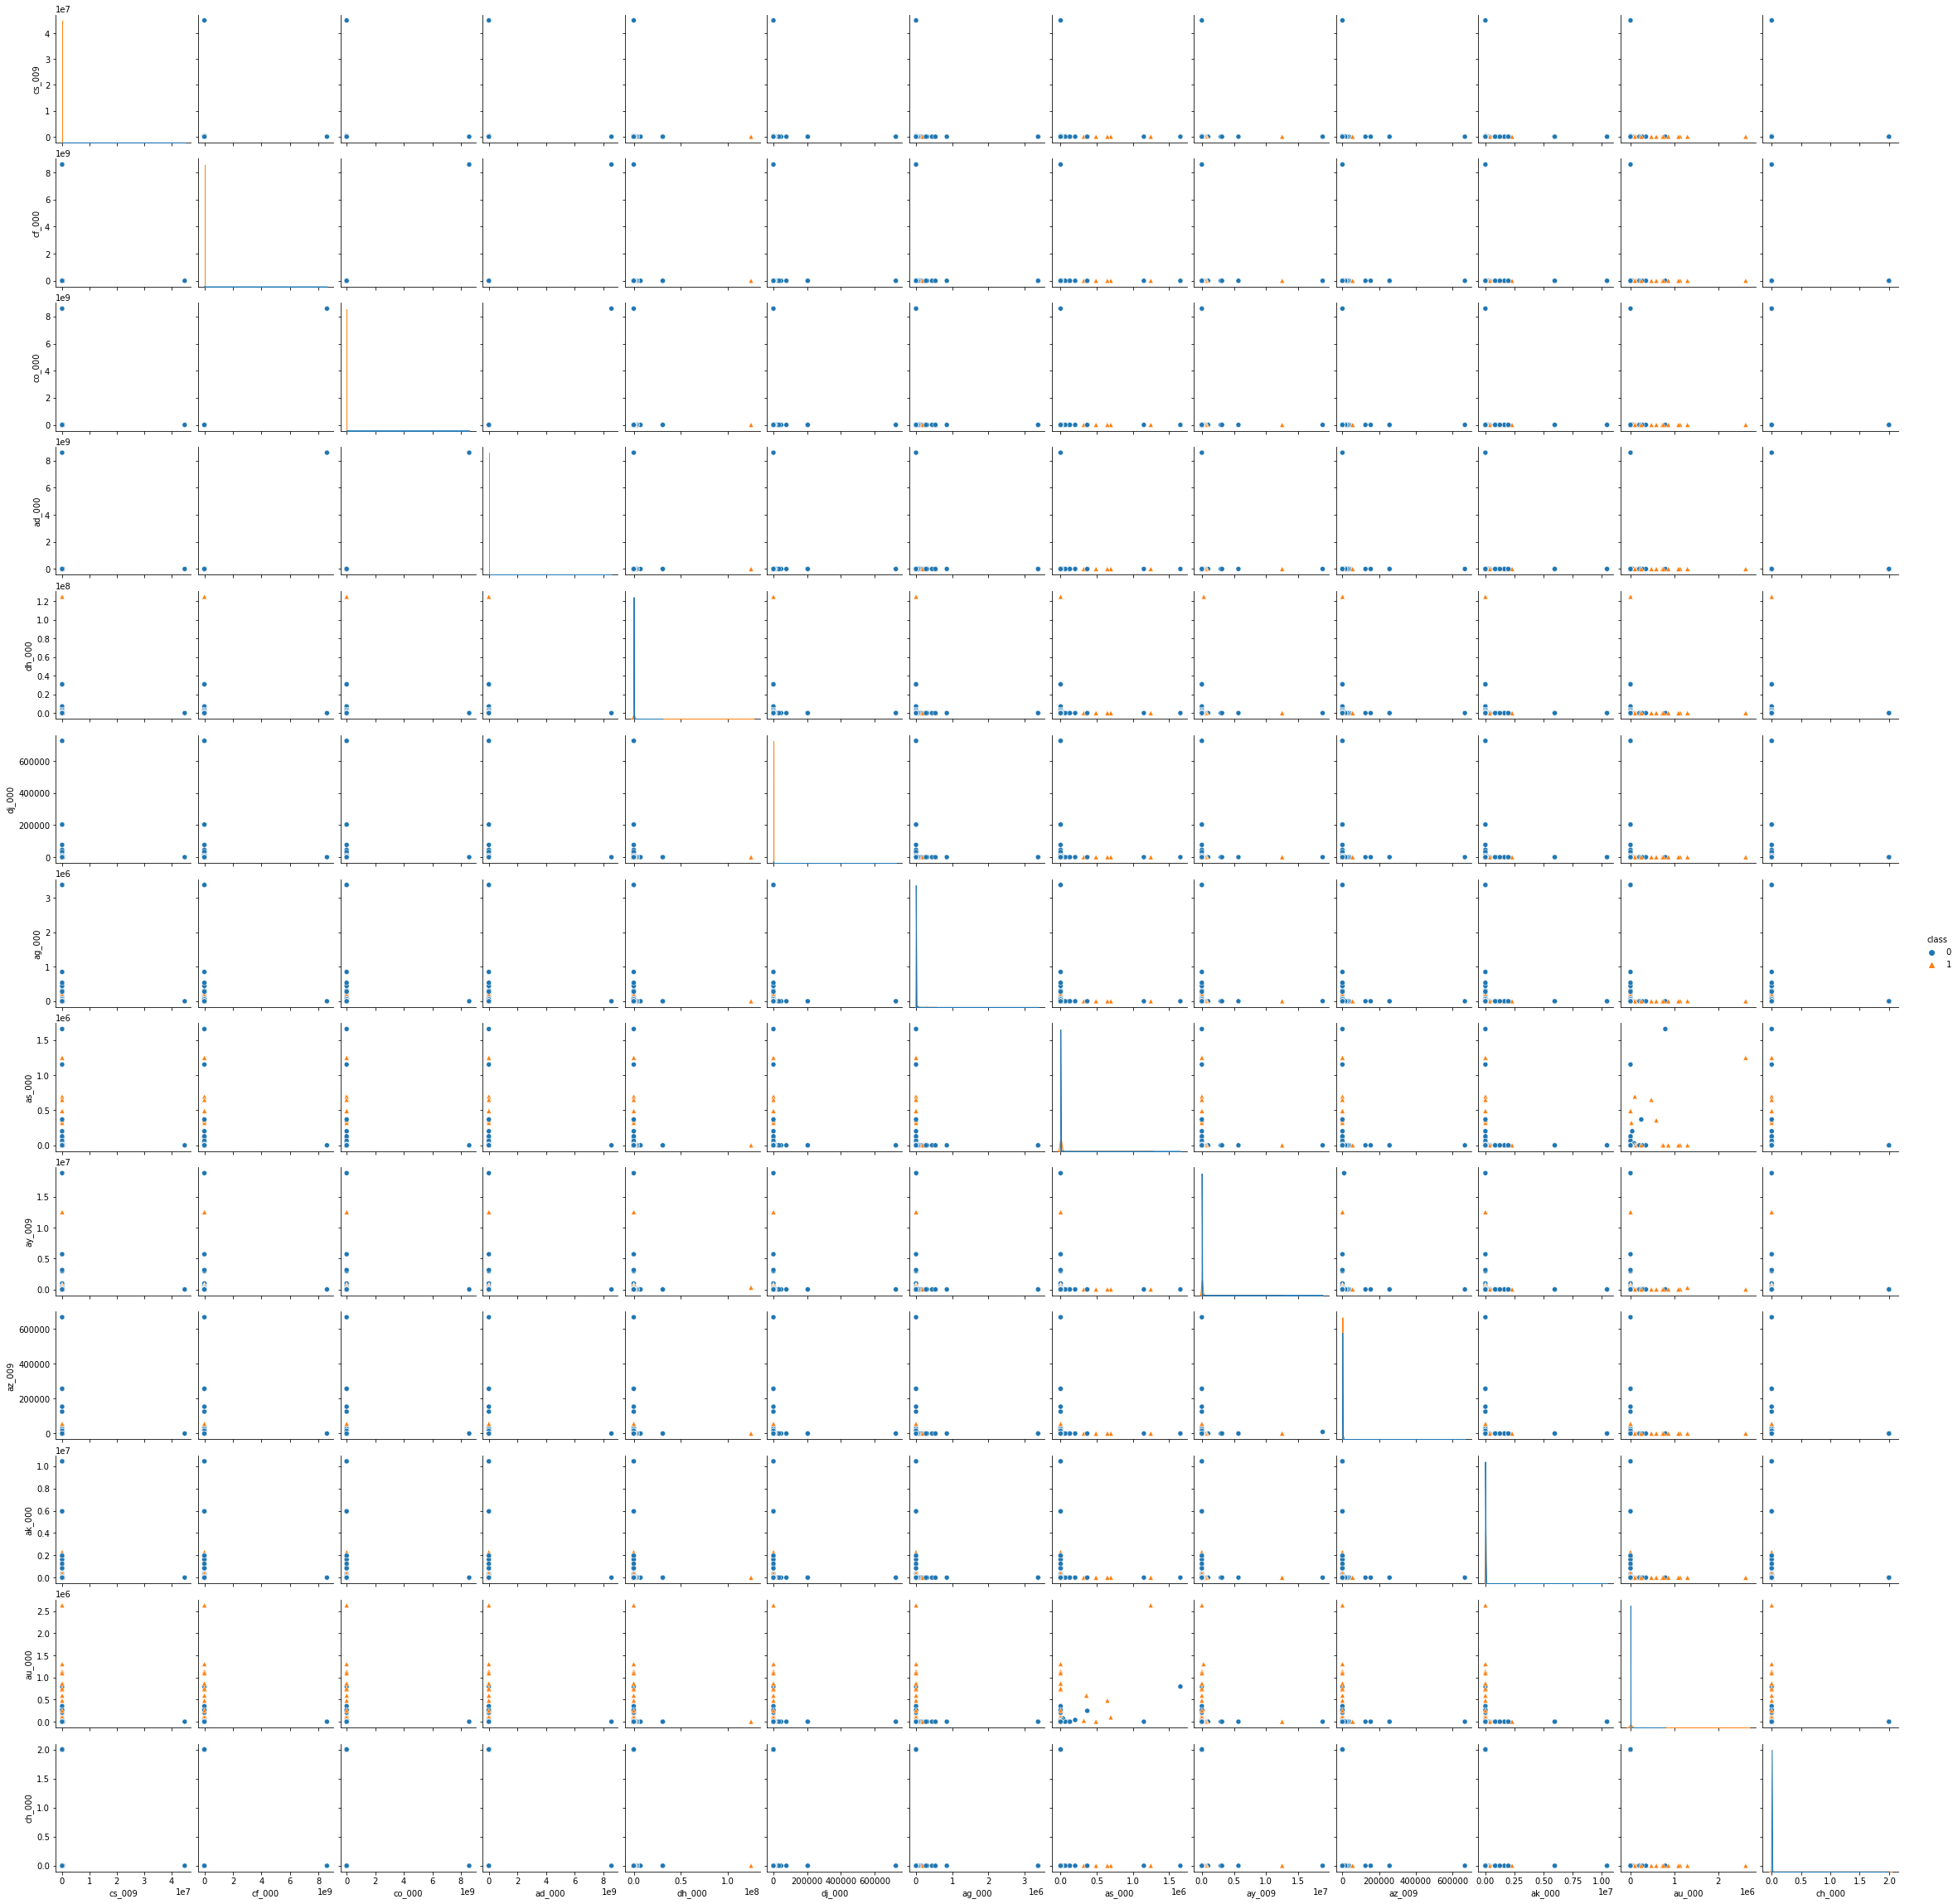

In [54]:
# scatterplot of the selected features
scatter_plt = sns.pairplot(aps_trainX_selected, kind='scatter', hue ='class',markers=["o", "^"])

It's hard to draw a conclusion of significance of the features just by scatter plots. 

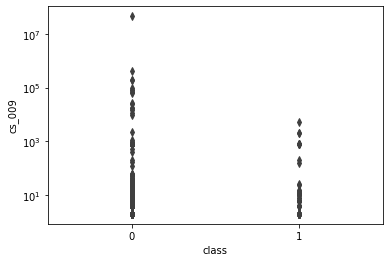

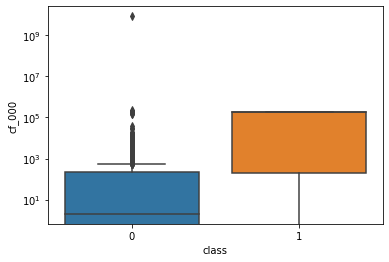

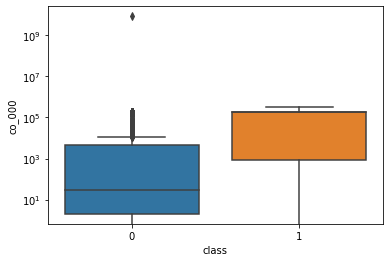

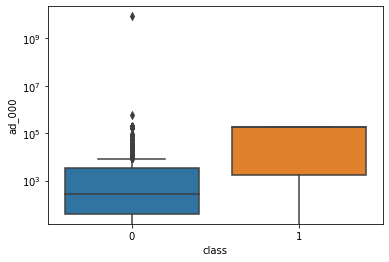

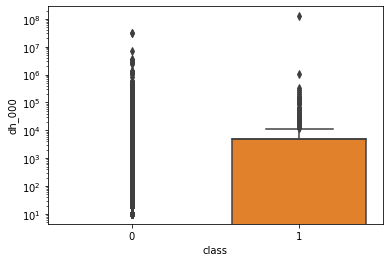

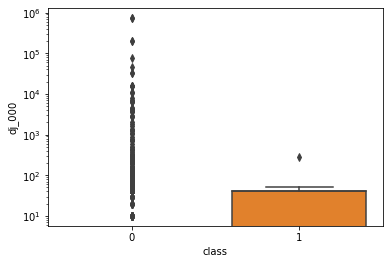

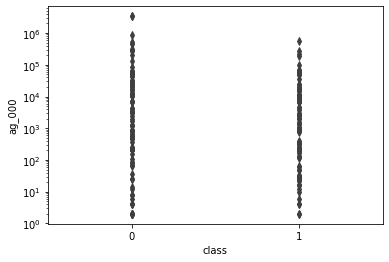

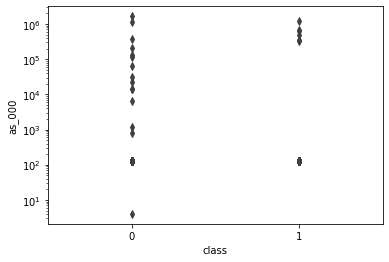

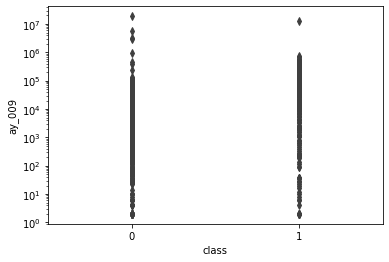

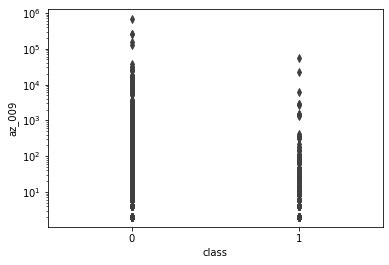

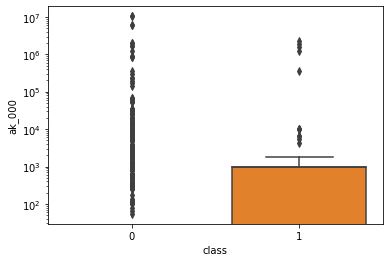

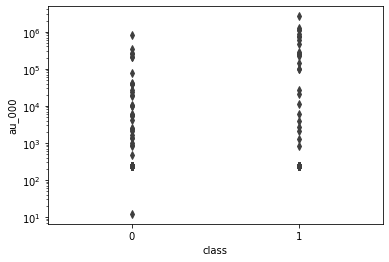

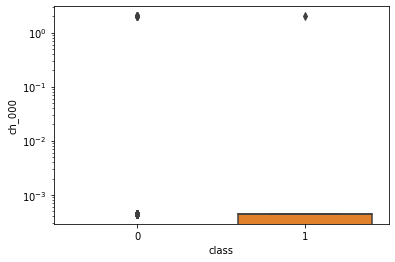

In [55]:
# boxplot of the selected features
classlabel = aps_trainX_selected['class']
for i in range(1,len(aps_trainX_selected.columns)):
    feature = aps_trainX_selected[aps_trainX_selected.columns[i]]
    boxplt = sns.boxplot(x = classlabel, y = feature)
    boxplt.set(yscale="log")
    plt.show()

The imputation strategy with mean can be easily affected by an outlier. Here I show the log scale in value to see the distributions in the scatter plot and box plot.

### Determine the number of positive and negative data. Is this data set imbalanced?

In [56]:
pos_num = len(aps_data[aps_data['class'] == 'pos'])
neg_num = len(aps_data[aps_data['class'] == 'neg'])
print("Number of positive data = {}, Number of negative data = {}".format(pos_num, neg_num))

Number of positive data = 1375, Number of negative data = 74625


In [57]:
# neg = 0 and pos = 1
aps_trainY.value_counts()

0    59000
1     1000
Name: class, dtype: int64

In [58]:
# neg = 0 and pos = 1
aps_testY.value_counts()

0    15625
1      375
Name: class, dtype: int64

Yes, we can observe that the data set is imbalanced as evident by the number of positive and negative class data present in the data set.

## Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them.

Random Forest classifier with Class Imbalance:

Train Metrics:
Accuracy = 0.9923
Train error = 0.0077
Confusion Matrix:
 [[58972    28]
 [  435   565]]
Misclassification = 463


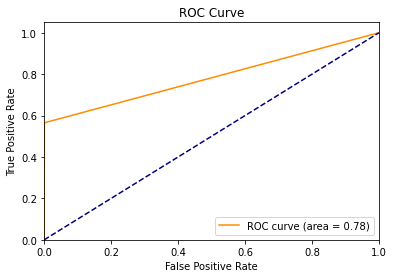


Test Metrics:
Accuracy = 0.988125
Test error = 0.0119
Confusion Matrix:
 [[15614    11]
 [  179   196]]
Misclassification = 190


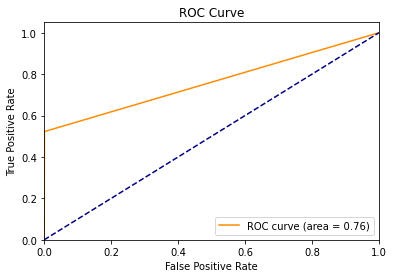

In [59]:
print("Random Forest classifier with Class Imbalance:\n")
#Create a Gaussian Classifier
clf=RandomForestClassifier(max_depth = 5, oob_score=True)
#Train the model using the training sets
clf.fit(aps_trainX,aps_trainY)
ytrain_pred=clf.predict(aps_trainX)
ytest_pred=clf.predict(aps_testX)

# Model Accuracy, how often is the classifier correct?
train_accuracy = round(accuracy_score(aps_trainY, ytrain_pred), 4)
train_error = round(1 - train_accuracy, 4)
print("Train Metrics:\nAccuracy = {}\nTrain error = {}".format(train_accuracy, train_error))
compute_metrics(aps_trainY, ytrain_pred)
test_accuracy = accuracy_score(aps_testY, ytest_pred)
test_error = round(1 - test_accuracy, 4)
print("\nTest Metrics:\nAccuracy = {}\nTest error = {}".format(test_accuracy, test_error))
compute_metrics(aps_testY, ytest_pred)

### Calculate Out of Bag error estimate for your random forest and compare it to the test error.

In [60]:
train_oob_error = round(1 - clf.oob_score_, 4)
print("Out of Bag error = {}\nTest error = {}".format(train_oob_error, test_error))

Out of Bag error = 0.009
Test error = 0.0119


Comparing the test error with the out-of-bag error, the values turn out be close. The out-of-bag predictions are not prone to overfitting, as each prediction is only made by learners that did not use the observation for training almost like test set.<br>
Building random forest on the highly unbalanced data, we can observe that our model seems to be easily classifying datapoints to negative class (majority), which helps in achieving high accuracy due to the large amount of correct classification of the majority class, but low TPR, which means a lower ability to correctly classify the positive class (minority).

## Random Forest with Compensating for Class Imbalance

### Research how class imbalance is addressed in random forests.

A simple technique for modifying a decision tree for imbalanced classification is to change the weight that each class has when calculating the “impurity” score of a chosen split point.<br>
Impurity measures how mixed the groups of samples are for a given split in the training dataset and is typically measured with Gini or entropy. The calculation can be biased so that a mixture in favor of the minority class is favored, allowing some false positives for the majority class.<br>
This modification of random forest is referred to as Weighted Random Forest.<br>

This can be achieved by setting the class_weight argument on the RandomForestClassifier class.<br>
This argument takes a dictionary with a mapping of each class value (e.g. 0 and 1) to the weighting. The argument value of 'balanced' can be provided to automatically use the inverse weighting from the training dataset, giving focus to the minority class.

### Compensate for class imbalance in your random forest and repeat 2.3.

Random Forest classifier with compensation for Class Imbalance:

Train Metrics:
Accuracy = 0.9593
Train error = 0.0407
Confusion Matrix:
 [[56585  2415]
 [   29   971]]
Misclassification = 2444


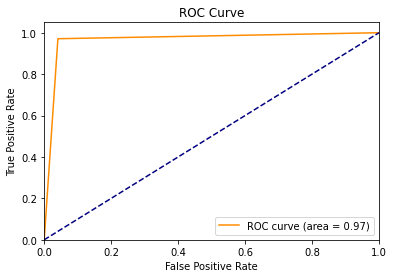


Test Metrics:
Accuracy = 0.9604375
Test error = 0.0396
Confusion Matrix:
 [[15008   617]
 [   16   359]]
Misclassification = 633


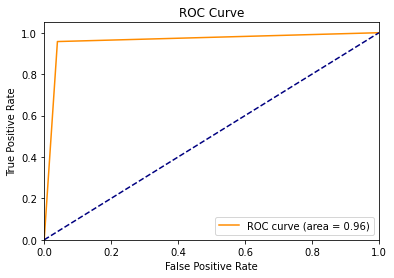

In [61]:
print("Random Forest classifier with compensation for Class Imbalance:\n")
#Create a Gaussian Classifier
clf = RandomForestClassifier(max_depth = 5, oob_score=True, class_weight='balanced')
#Train the model using the training sets
clf.fit(aps_trainX,aps_trainY)
ytrain_pred = clf.predict(aps_trainX)
ytest_pred = clf.predict(aps_testX)

# Model Accuracy, how often is the classifier correct?
train_accuracy = round(accuracy_score(aps_trainY, ytrain_pred), 4)
train_error = round(1 - train_accuracy, 4)
print("Train Metrics:\nAccuracy = {}\nTrain error = {}".format(train_accuracy, train_error))
compute_metrics(aps_trainY, ytrain_pred)
test_accuracy = accuracy_score(aps_testY, ytest_pred)
test_error = round(1 - test_accuracy, 4)
print("\nTest Metrics:\nAccuracy = {}\nTest error = {}".format(test_accuracy, test_error))
compute_metrics(aps_testY, ytest_pred)

In [62]:
train_oob_error = round(1 - clf.oob_score_, 4)
print("Out of Bag error = {}\nTest error = {}".format(train_oob_error, test_error))

Out of Bag error = 0.0417
Test error = 0.0396


### Compare the results with those of 2.3.

For the test accuracy, we can see that the random forest classifier with class imbalance has a better overall performance. But, as the 'neg' samples are significantly more than 'pos' samples, it is possible that the model tends to predict a sample as 'neg' to reach a higher accuracy and so, causing low TPR. <br>
If we have a detailed observation of the confusion matrices, the compensated case (when class_weight='balanced') has a remarkable better prediction for 'pos' class than earlier classifier for imbalanced class, hence reducing the False negative rate. Thus, it has a lower accuracy but a better TPR on the test set, which means a better ability to classify the minority class correctly. <br>
In sum, with compensating for class imbalance, we sacrifice our accuracy but get a better prediction on 'pos' class.

## Model Trees

In [63]:
# write imputed train and test files for Weka
weka_train_path = '../data/weka_train.csv'
weka_test_path = '../data/weka_test.csv'
aps_traindf['class'] = strlabels_train
aps_traindf.to_csv(weka_train_path, index=False)
aps_testdf['class'] = strlabels_test
aps_testdf.to_csv(weka_test_path, index=False)

### Train Logistic Model Trees for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model.

In [64]:
import weka.core.jvm as jvm
import javabridge
from javabridge import JWrapper, JClassWrapper
from javabridge import JavaException
jvm.start(packages=True)
from weka.classifiers import Classifier, Evaluation, FilteredClassifier
from weka.core.converters import Loader
from weka.core.classes import Random
import weka.plot.classifiers as plcls

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['C:\\Users\\saini\\anaconda3\\Lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\Users\\saini\\anaconda3\\Lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\Users\\saini\\anaconda3\\Lib\\site-packages\\javabridge\\jars\\cpython.jar', 'C:\\Users\\saini\\anaconda3\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'C:\\Users\\saini\\anaconda3\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


In [65]:
# load data and specify the column of label
weka_loader = Loader(classname="weka.core.converters.CSVLoader")
weka_train = weka_loader.load_file(weka_train_path)
weka_test = weka_loader.load_file(weka_test_path)
weka_train.class_index = 0
weka_test.class_index = 0

In [66]:
lmt = Classifier(classname='weka.classifiers.trees.LMT')
evl = Evaluation(weka_train)
evl.crossvalidate_model(classifier=lmt, data=weka_train, num_folds = 5, rnd=Random(60000))

### Report the Confusion Matrix, ROC, and AUC for training and test sets.

Train Metrics:
Accuracy = 0.992

Train error = 0.008

Confusion matrix:
 [[58823.   177.]
 [  304.   696.]]

Correctly Classified Instances       59519               99.1983 %
Incorrectly Classified Instances       481                0.8017 %
Kappa statistic                          0.7391
Mean absolute error                      0.011 
Root mean squared error                  0.0821
Relative absolute error                 33.5878 %
Root relative squared error             64.1084 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.304    0.995      0.997    0.996      0.741    0.962     0.998     neg
                 0.696    0.003    0.797      0.696    0.743      0.741    0.962     0.741     pos
Weighted Avg.    0.992    0.299    0.992      0.992    0.992      0.741    0.962     0.993     



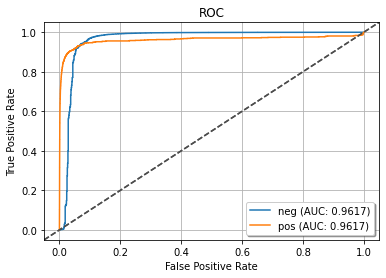

In [67]:
# report confusion matrix
print("Train Metrics:")
print("Accuracy =", round(evl.percent_correct/100, 4))
print("\nTrain error =", round(evl.percent_incorrect/100, 4))
print("\nConfusion matrix:\n", evl.confusion_matrix)
print(evl.summary())
print(evl.class_details())
# plot ROC curve and get AUC
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [68]:
lmt.build_classifier(weka_train)

Test Metrics:
Accuracy = 0.9904
Test error = 0.0096
Confusion Matrix:
 [[15579    46]
 [  108   267]]
Misclassification = 154


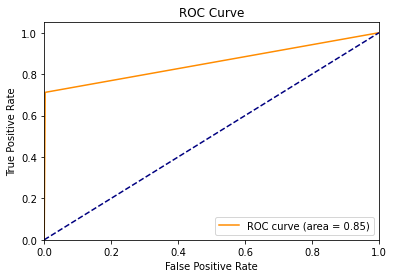

In [69]:
weka_test_predict = []
# make prediction for each instance
for inst in weka_test:
    weka_test_predict.append(lmt.classify_instance(inst))
test_accuracy = round(accuracy_score(aps_testY, weka_test_predict), 4)
test_error = round(1 - test_accuracy, 4)
print("Test Metrics:\nAccuracy = {}\nTest error = {}".format(test_accuracy, test_error))
compute_metrics(aps_testY, weka_test_predict)

### Compare train and test error.

We can observe that the test error is little more than the train error but almost similar. Overall performance of the model is good even though the class is imbalanced which indicates that the model might have given priority to the majority class ('neg') during classification thus reaching high accuracy.

## Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.

In [70]:
import weka.core.packages as packages

# after the install, the runtime must be restarted!
pkg_name = "SMOTE"
if not packages.is_installed(pkg_name):
    packages.install_package(pkg_name)
    print("%s package installed, please restart runtime" % pkg_name)

### Train a Logistic Model Tree using the pre-processed data and repeat 2.5.

Train metrics:

Accuracy = 0.9911

Train error = 0.0089

Confusion matrix:
 [[58756.   244.]
 [  288.   712.]]

Correctly Classified Instances       59468               99.1133 %
Incorrectly Classified Instances       532                0.8867 %
Kappa statistic                          0.7235
Mean absolute error                      0.0136
Root mean squared error                  0.0856
Relative absolute error                 41.4605 %
Root relative squared error             66.8887 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.996    0.288    0.995      0.996    0.995      0.724    0.965     0.998     neg
                 0.712    0.004    0.745      0.712    0.728      0.724    0.965     0.732     pos
Weighted Avg.    0.991    0.283    0.991      0.991    0.991      0.724    0.965     0.994     



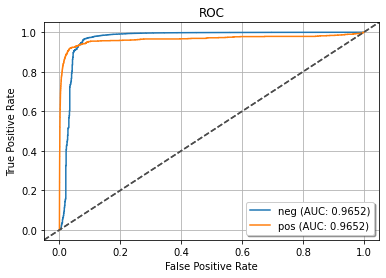

In [71]:
from weka.filters import Filter
SMOTE = Filter(classname="weka.filters.supervised.instance.SMOTE", options=["-S", "0"])

cls = Classifier(classname='weka.classifiers.trees.LMT')

fc = FilteredClassifier()
fc.filter = SMOTE
fc.classifier = cls

evl = Evaluation(weka_train)
evl.crossvalidate_model(fc, weka_train, 5, Random(1))

print("Train metrics:\n")
print("Accuracy =", round(evl.percent_correct/100, 4))
print("\nTrain error =", round(evl.percent_incorrect/100, 4))
print("\nConfusion matrix:\n", evl.confusion_matrix)
print(evl.summary())
print(evl.class_details())
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [72]:
fc.build_classifier(weka_train)

Test Metrics:
Accuracy = 0.9906
Test error = 0.0094
Confusion Matrix:
 [[15578    47]
 [  104   271]]
Misclassification = 151


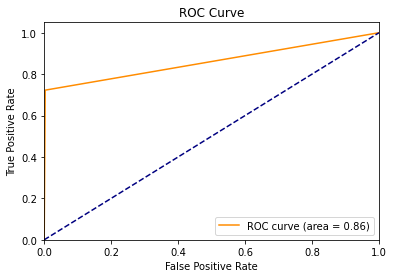

In [73]:
weka_test_predict = []
# make prediction for each instance
for inst in weka_test:
    weka_test_predict.append(fc.classify_instance(inst))
test_accuracy = round(accuracy_score(aps_testY, weka_test_predict), 4)
test_error = round(1 - test_accuracy, 4)
print("Test Metrics:\nAccuracy = {}\nTest error = {}".format(test_accuracy, test_error))
compute_metrics(aps_testY, weka_test_predict)

### Compare the uncompensated case with SMOTE.

Comparing SMOTE with the Logistic Model Trees built on imbalanced class (uncompensated case), the test error decreases (accuracy increases) when using SMOTE oversampling, it misclassifies the majority ('neg') class little more, but the TPR increases slightly, meaning the ability of classifying the minority class becomes better. Therefore, by using oversampling, we lose little accuracy for targeting the majority class, but have more tendency to find out the true 'pos' class. If we observe the confusion matrix, we can see a better precision of positive class which is the minority in our dataset. That means SMOTE can really help to improve the classification of minority class.

In [74]:
jvm.stop()

# ISLR 6.8.3

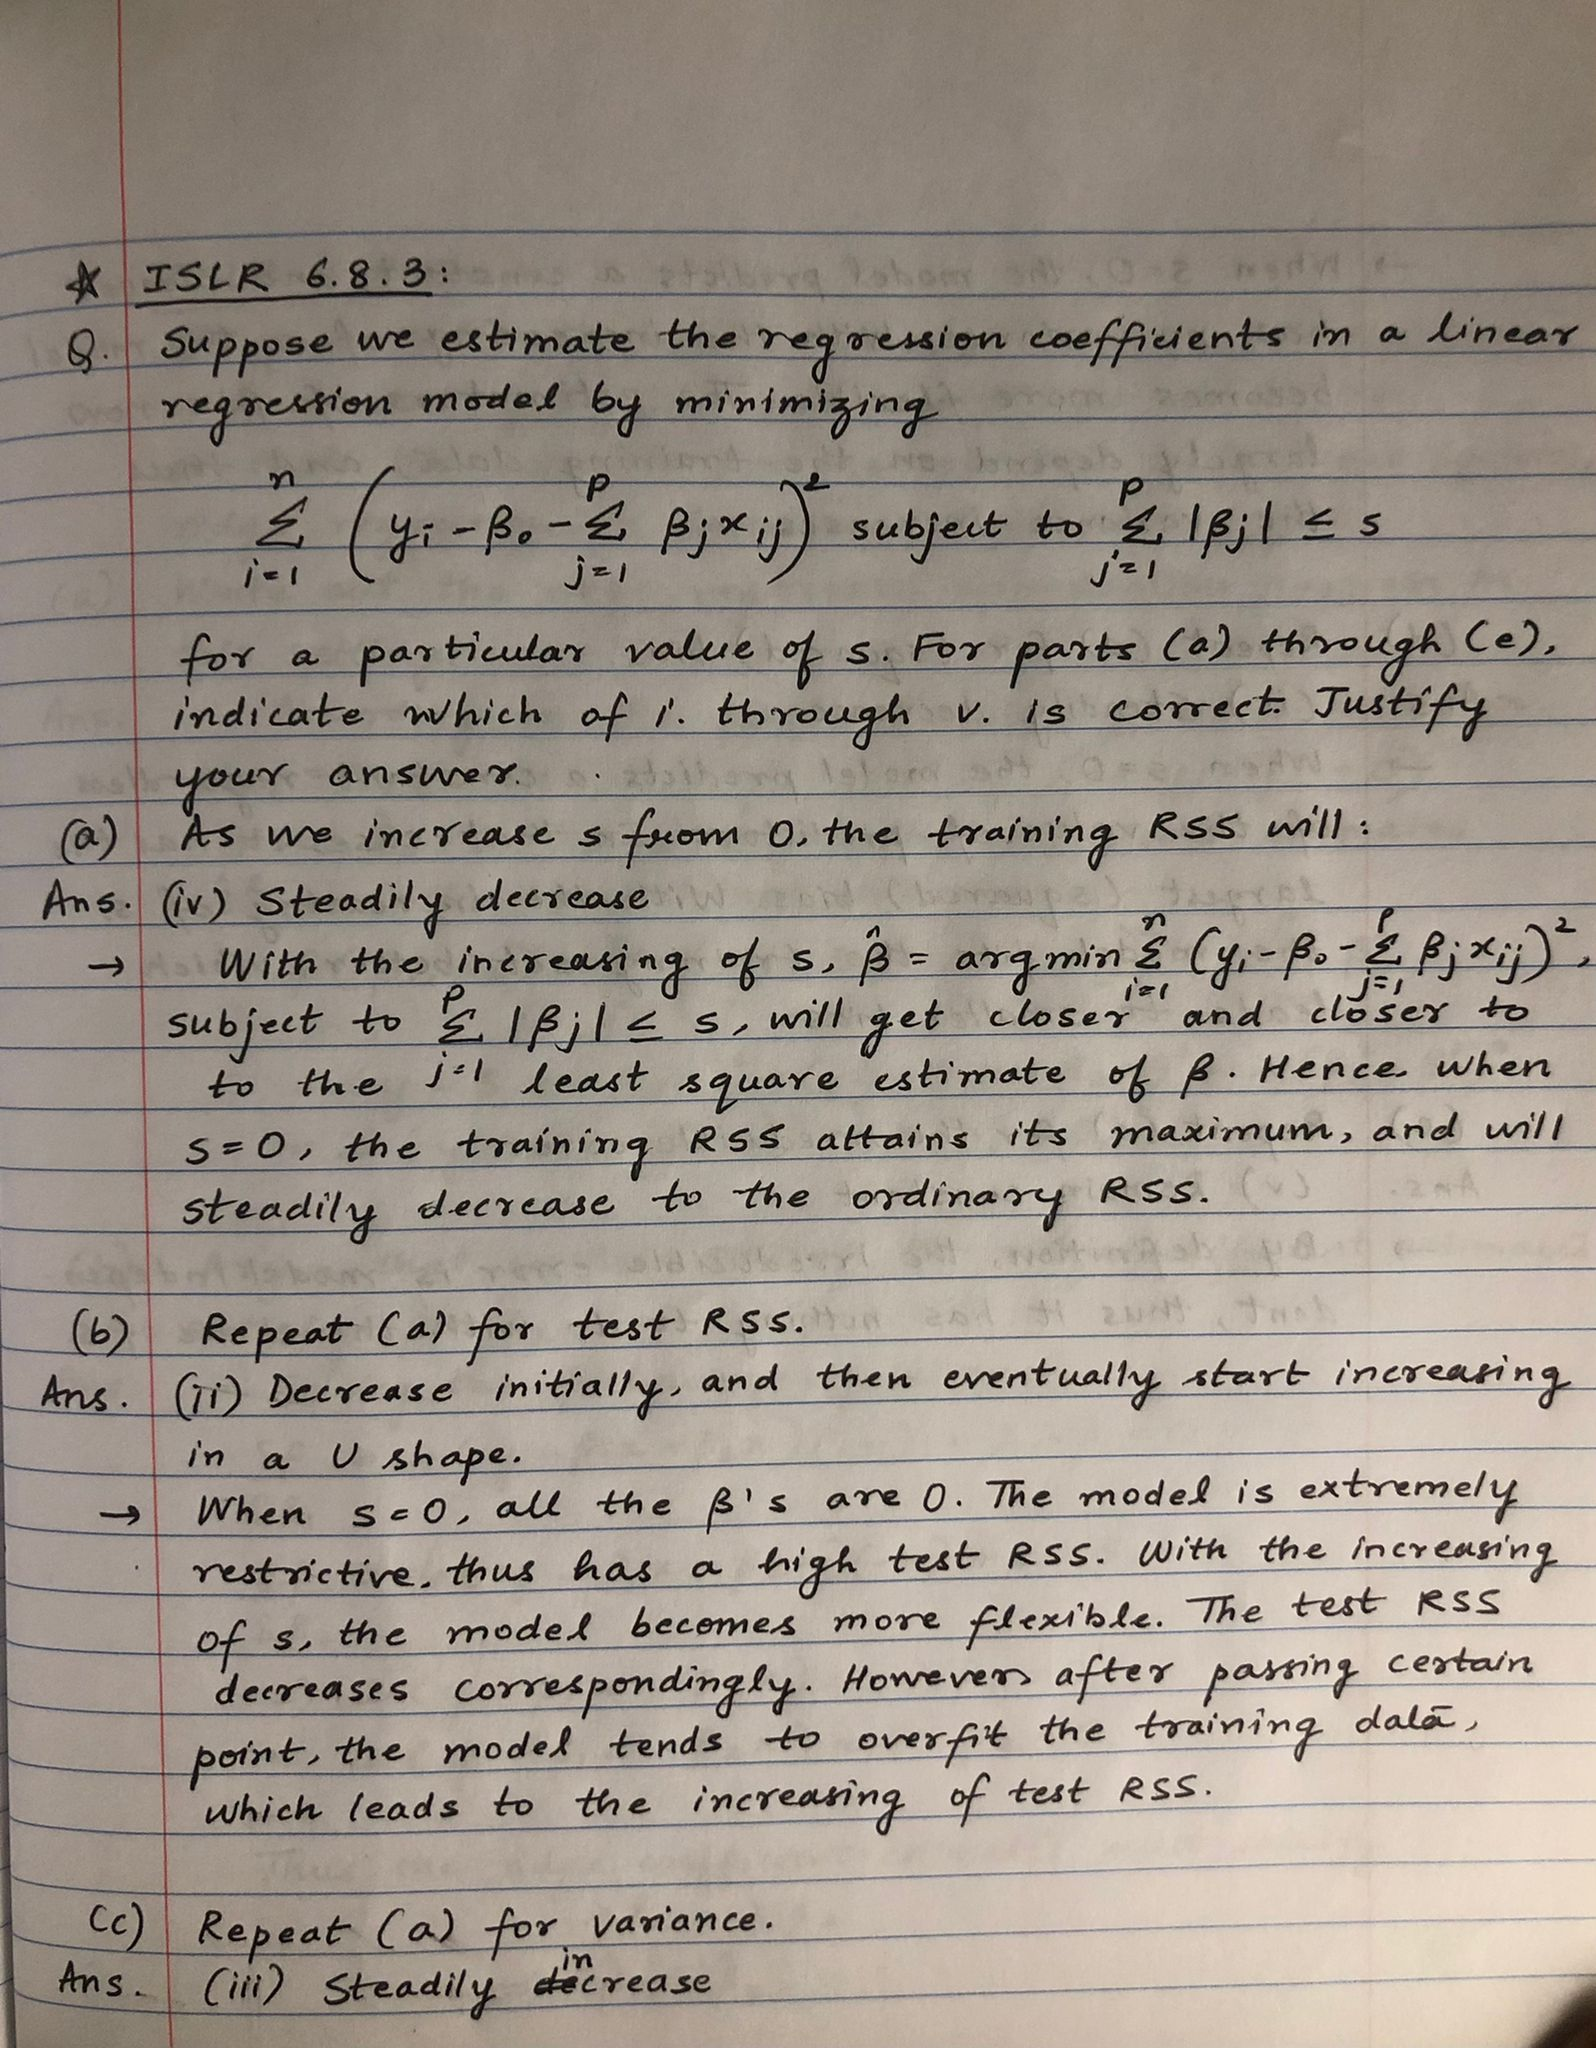

In [75]:
Image('../image/ISLR 6.8.3_1.jpeg')

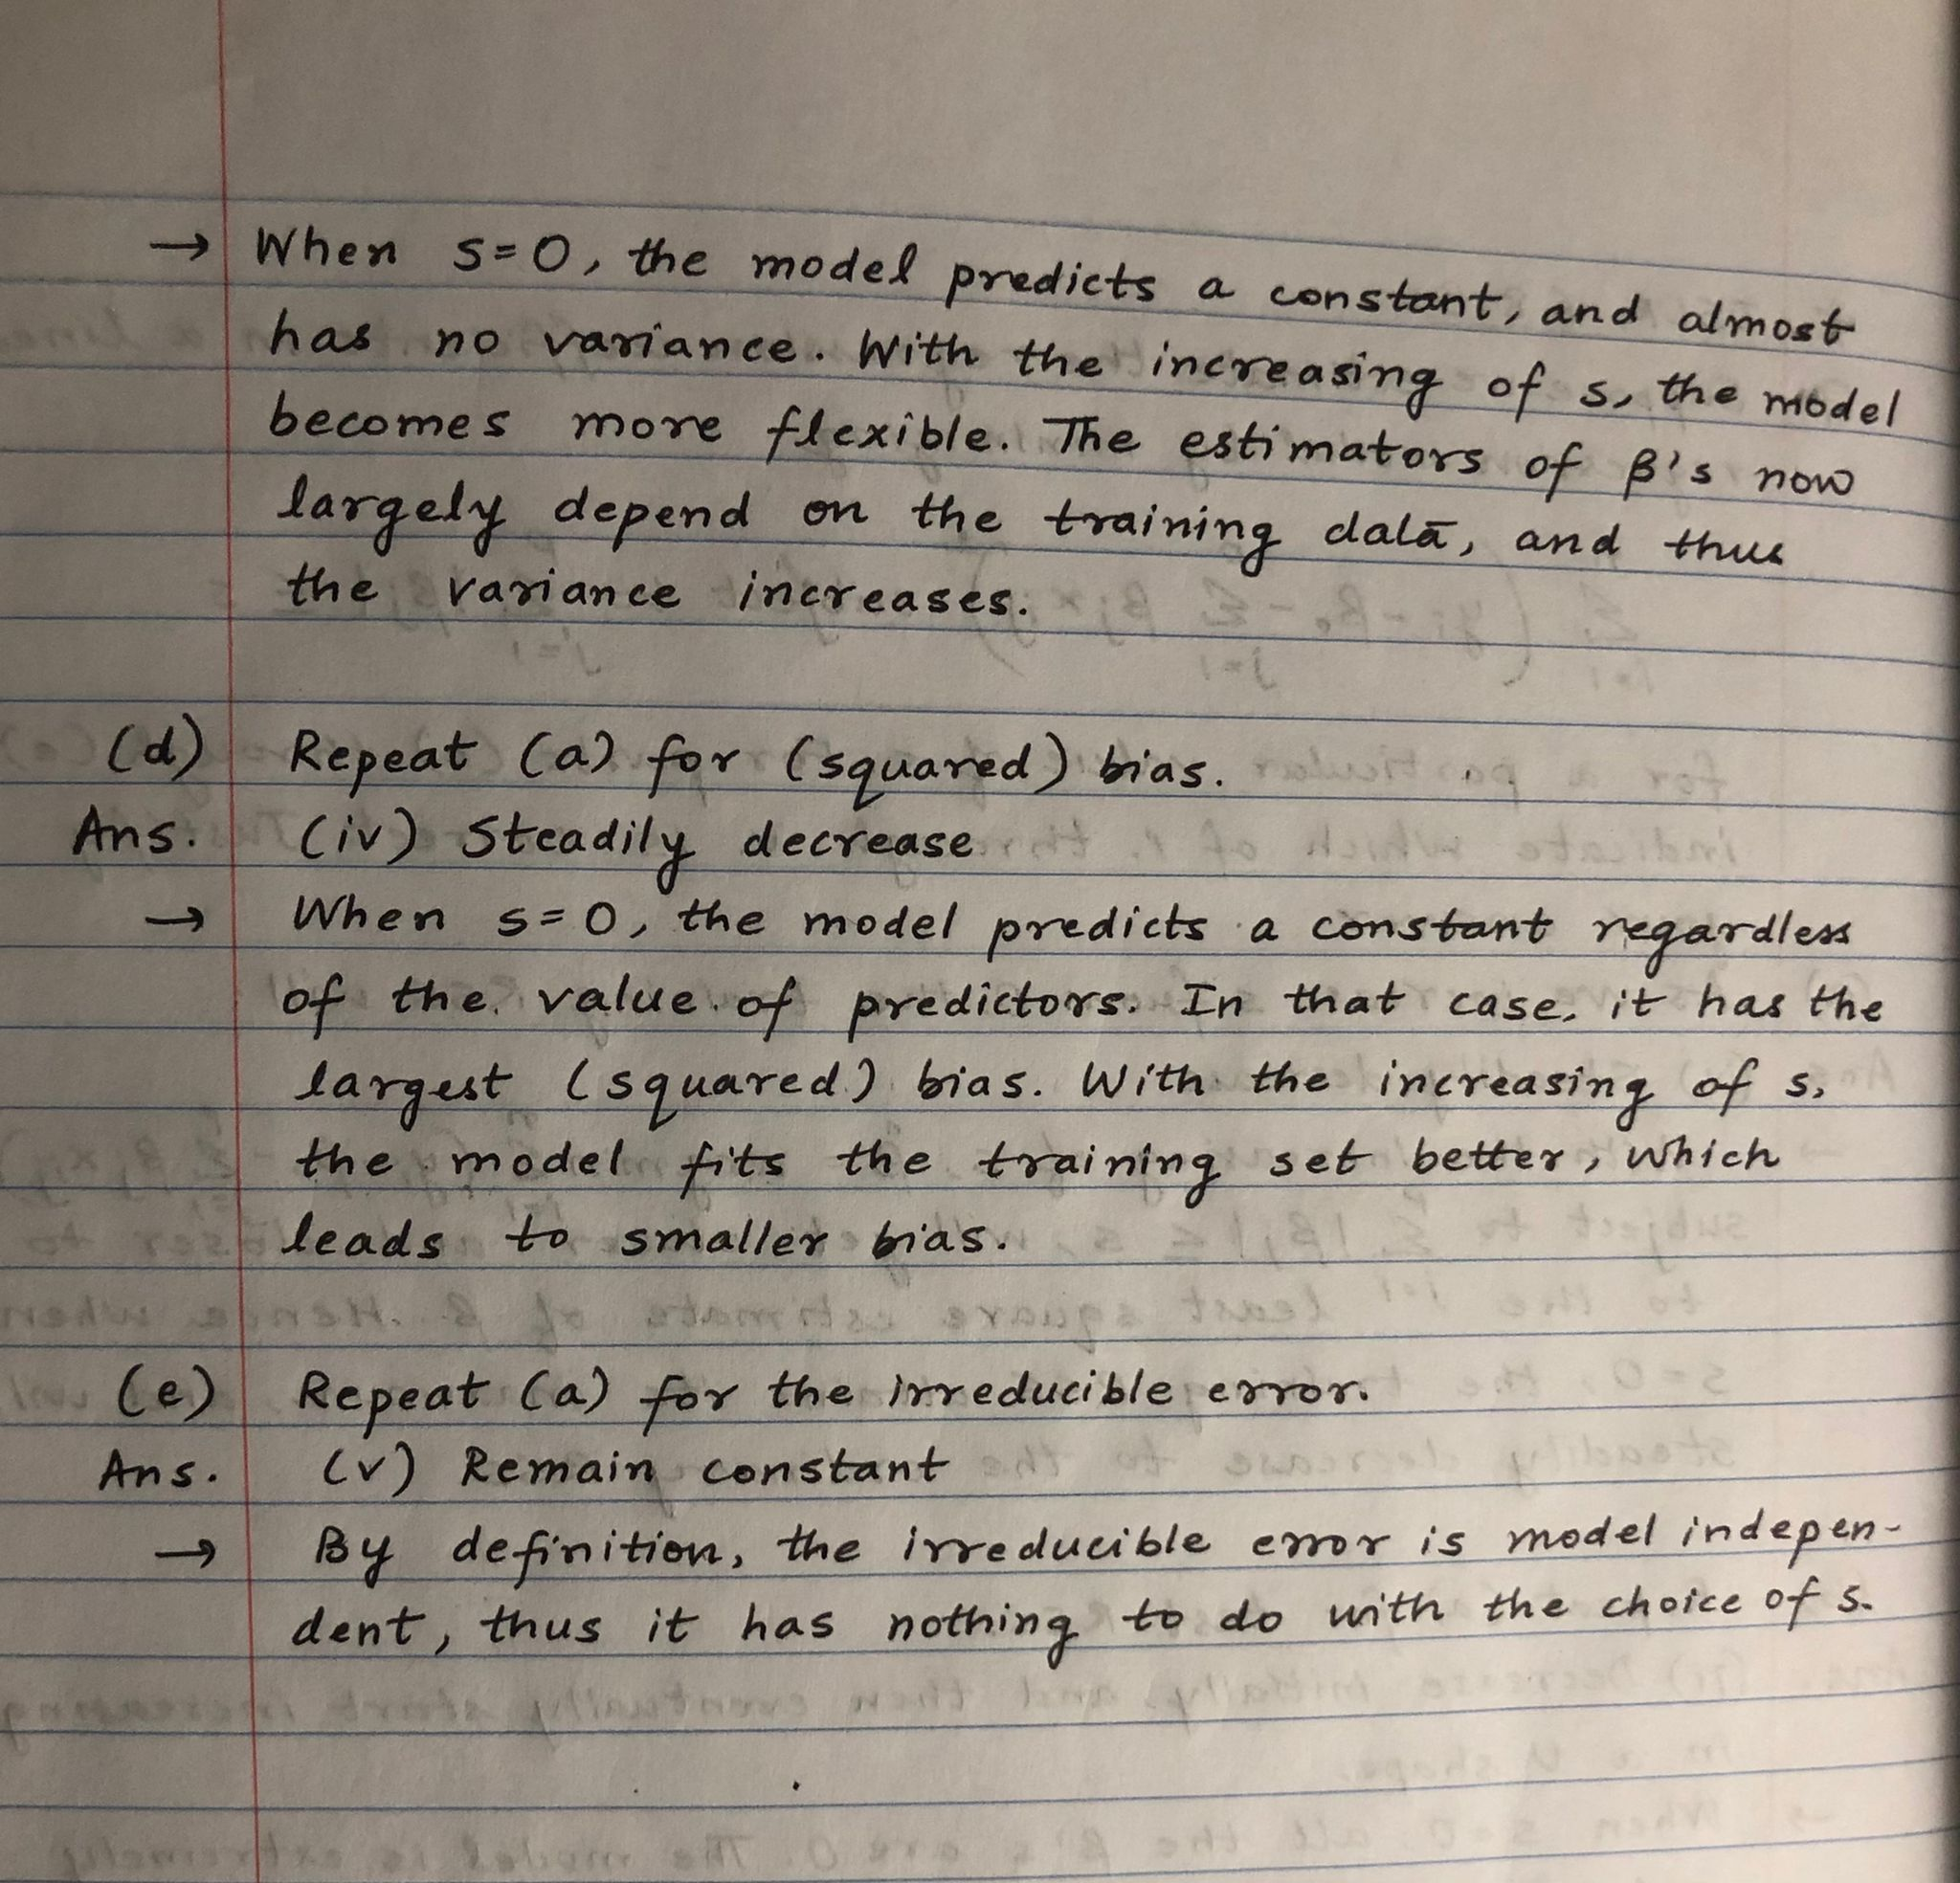

In [76]:
Image('../image/ISLR 6.8.3_2.jpeg')

# ISLR 6.8.5

It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting.

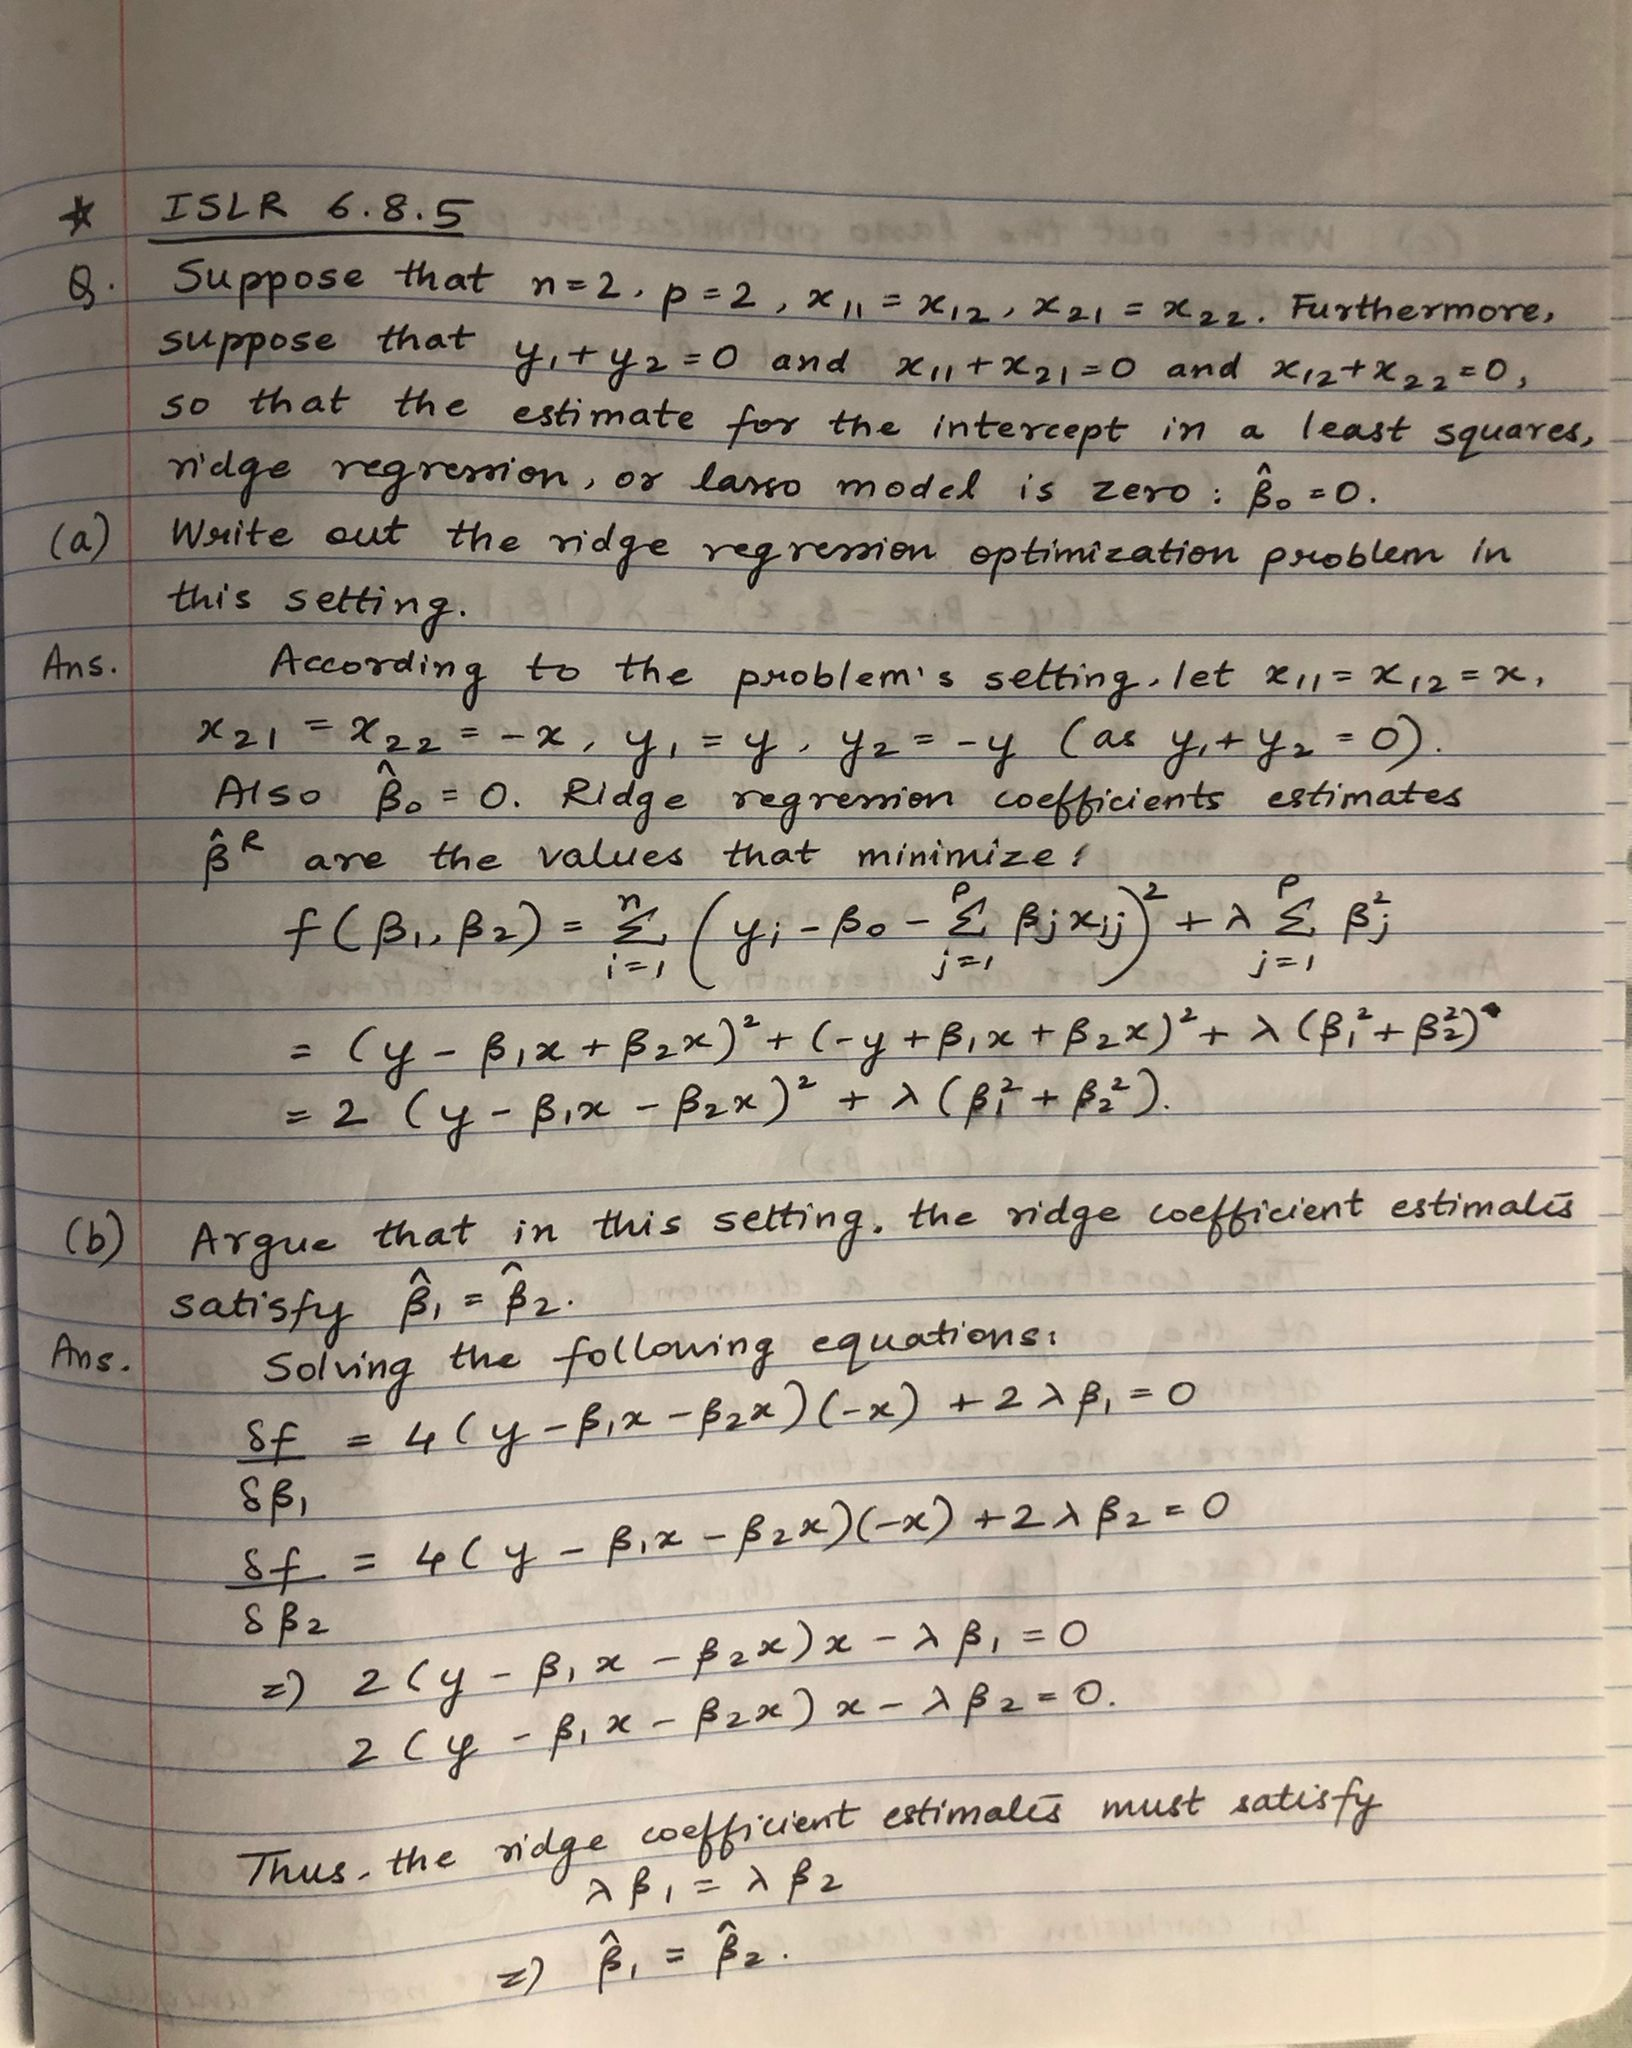

In [77]:
Image('../image/ISLR 6.8.5_1.jpeg')

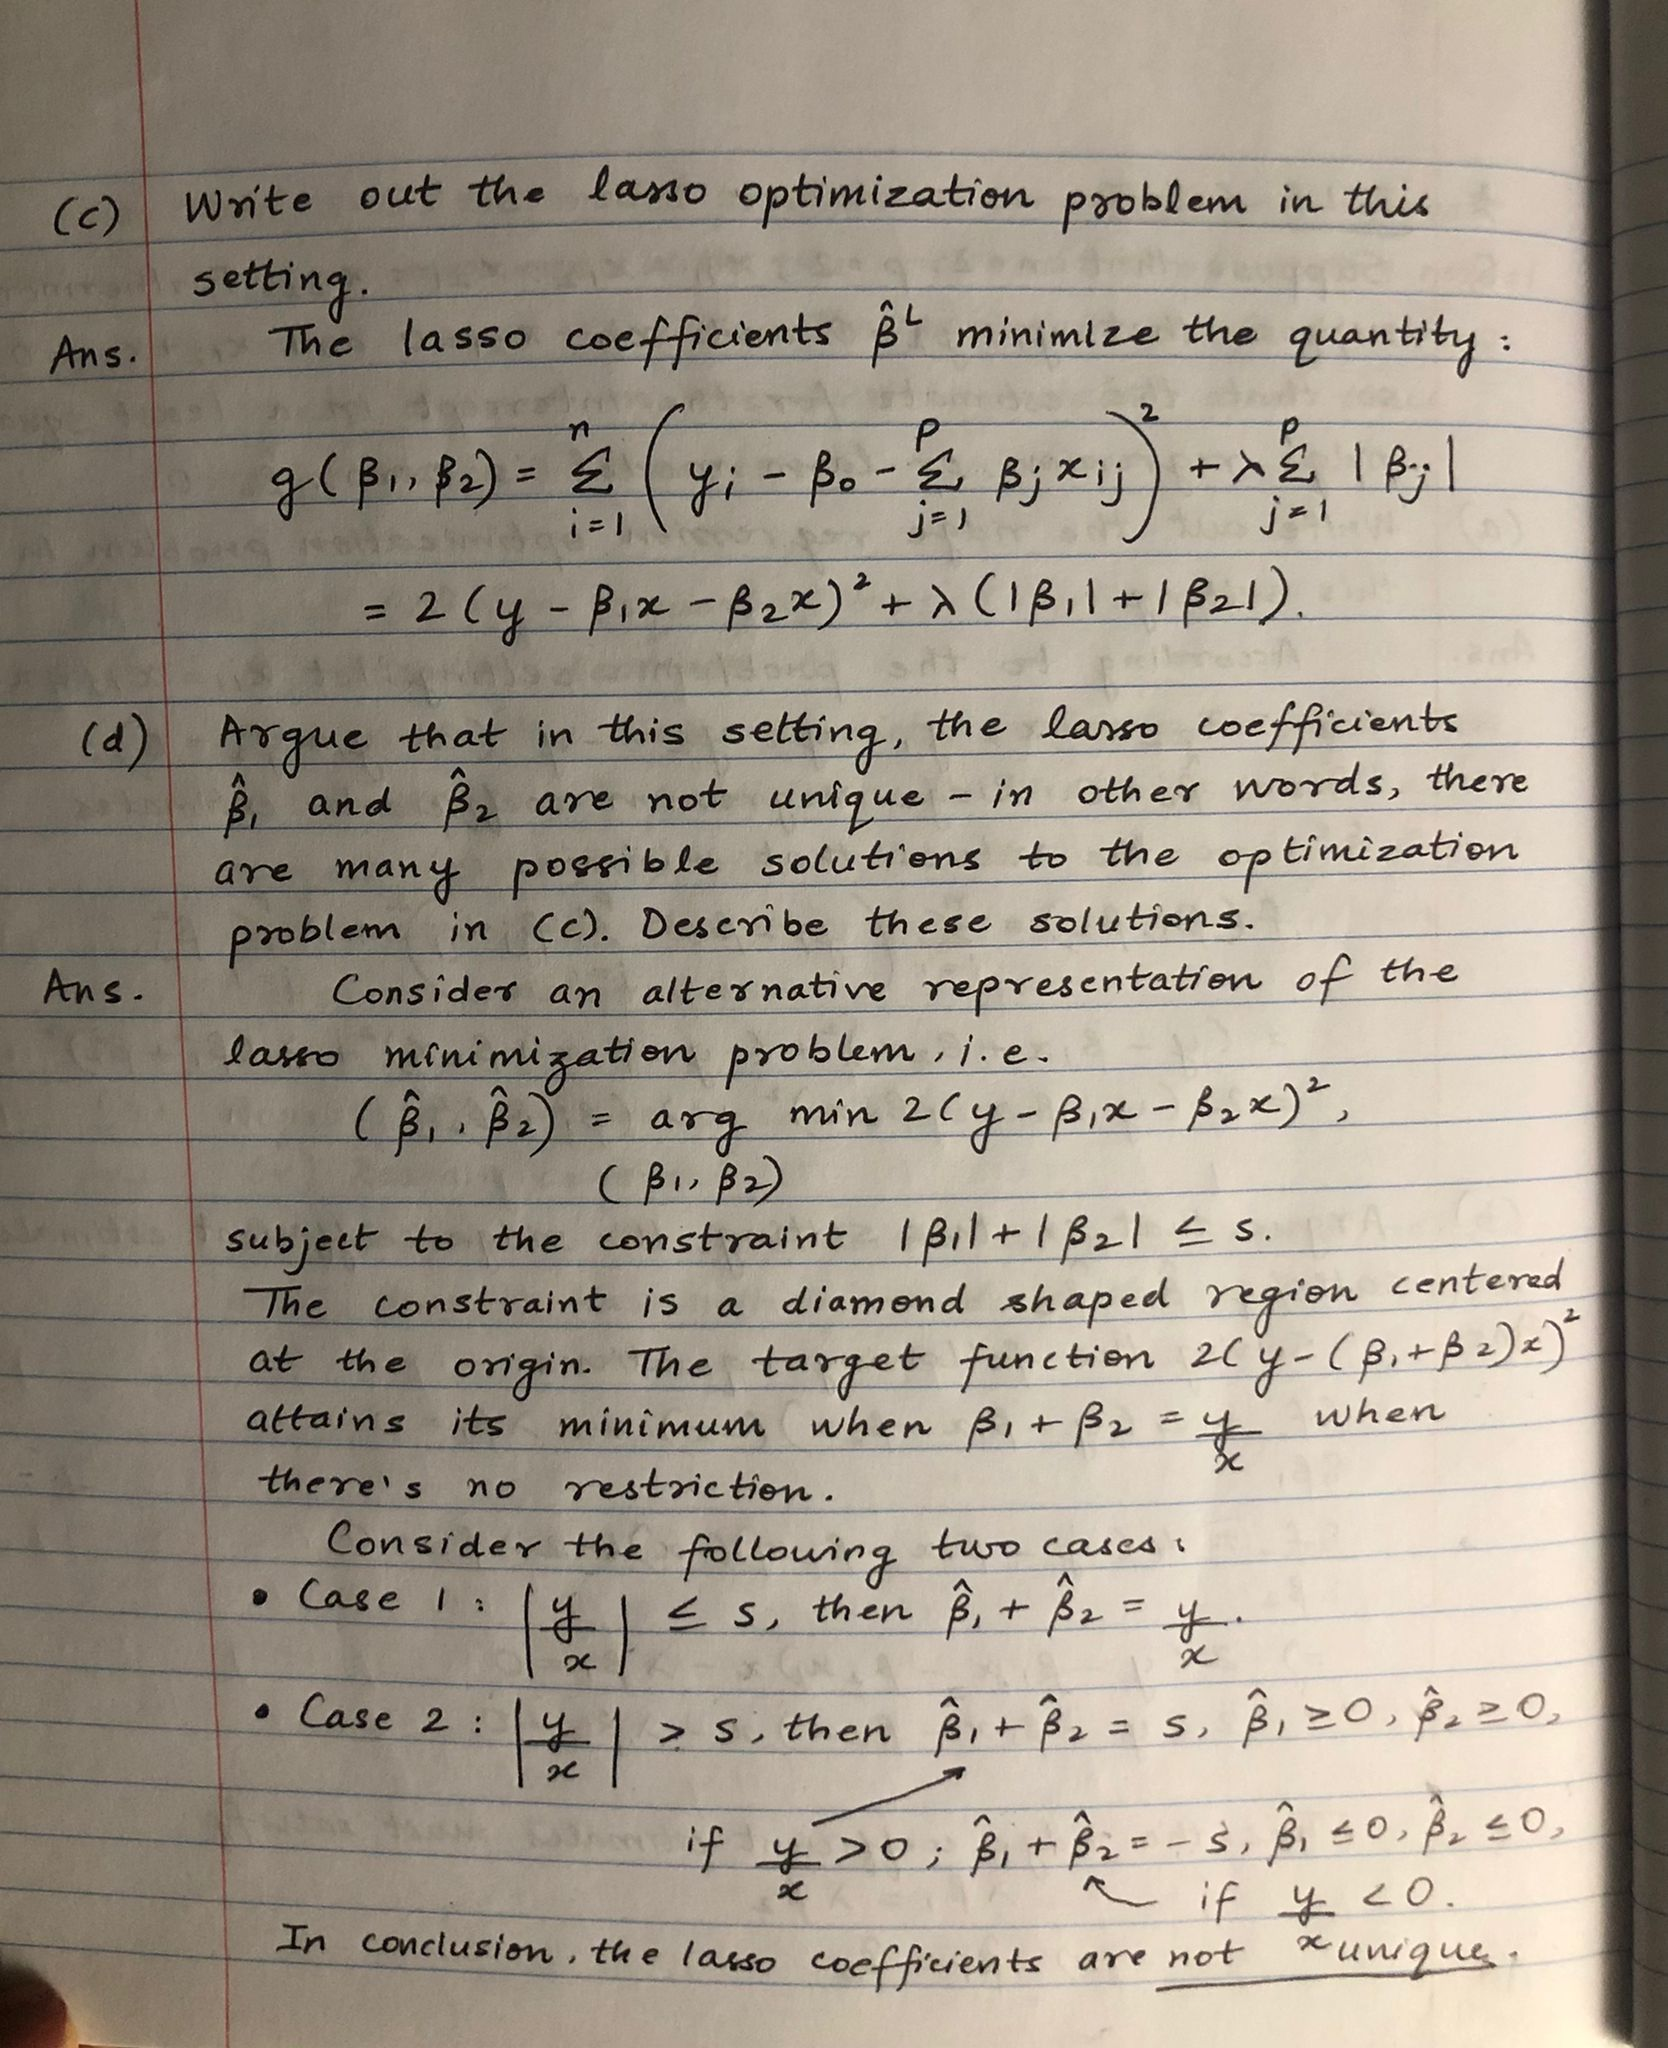

In [78]:
Image('../image/ISLR 6.8.5_2.jpeg')

# ISLR 8.4.5

Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X): <br>
0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75. <br>
There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

In [79]:
prob_list = [0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75]

In [80]:
# majority vote approach
red_count = sum(1 for i in prob_list if i >= 0.5)
green_count = sum(1 for i in prob_list if i < 0.5)

if red_count > green_count:
    print("With the majority vote approach, we classify X as Red as it is the most commonly occurring class among the 10 predictions.")
else:
    print("With the majority vote approach, we classify X as Green as it is the most commonly occurring class among the 10 predictions.")

With the majority vote approach, we classify X as Red as it is the most commonly occurring class among the 10 predictions.


In [81]:
# average probability approach
mean = sum(prob_list)/len(prob_list)

if mean >= 0.5:
    print("With the average probability approach, we classify X as Red as the average of the 10 probabilities is {}.".format(mean))
else:
    print("With the average probability approach, we classify X as Green as the average of the 10 probabilities is {}.".format(mean))

With the average probability approach, we classify X as Green as the average of the 10 probabilities is 0.45.


# ISLR 9.7.3

**Here we explore the maximal margin classifier on a toy data set. <br>
(a) We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label.<br>
Obs. X1 X2 Y<br>**
**1. 3 4 Red<br>**
**2. 2 2 Red<br>**
**3. 4 4 Red<br>**
**4. 1 4 Red<br>**
**5. 2 1 Blue<br>**
**6. 4 3 Blue<br>**
**7. 4 1 Blue<br>**
**Sketch the observations.**

In [82]:
dict = {'X1' : [3, 2, 4, 1, 2, 4, 4], 'X2' : [4, 2, 4, 4, 1, 3, 1], 'Y' : ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']}
df = pd.DataFrame.from_dict(dict)

In [83]:
from sklearn.svm import SVC

# create svm model
clf = SVC(kernel='linear', C=10000)
clf.fit(df.iloc[:, :-1], df.iloc[:, -1])

SVC(C=10000, kernel='linear')

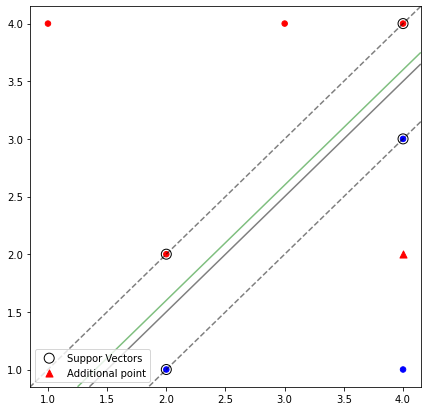

[0.99970703] [[-1.99941406  1.99941406]]


In [84]:
# plot graph
fig, ax = plt.subplots(figsize=(7, 7))

# scatter plot of sample points
ax.scatter(df.iloc[:, 0], df.iloc[:, 1], c = df.iloc[:, -1], s=30, cmap=plt.cm.Paired)

# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# hyperplane
lines1 = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], label="Decision Boundary")

# support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k', label="Suppor Vectors")

# a hyperplane that is not optimal
lines2 = ax.contour(XX, YY, Z - 0.2, colors='g', levels=[0], alpha=0.5, linestyles=['-'])

# point make the data NOT linear-separable
ax.scatter([4.0], [2.0], color='r', marker='^', s=50, label="Additional point")

ax.legend()
plt.show()

print(clf.intercept_, clf.coef_)

**(b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).**

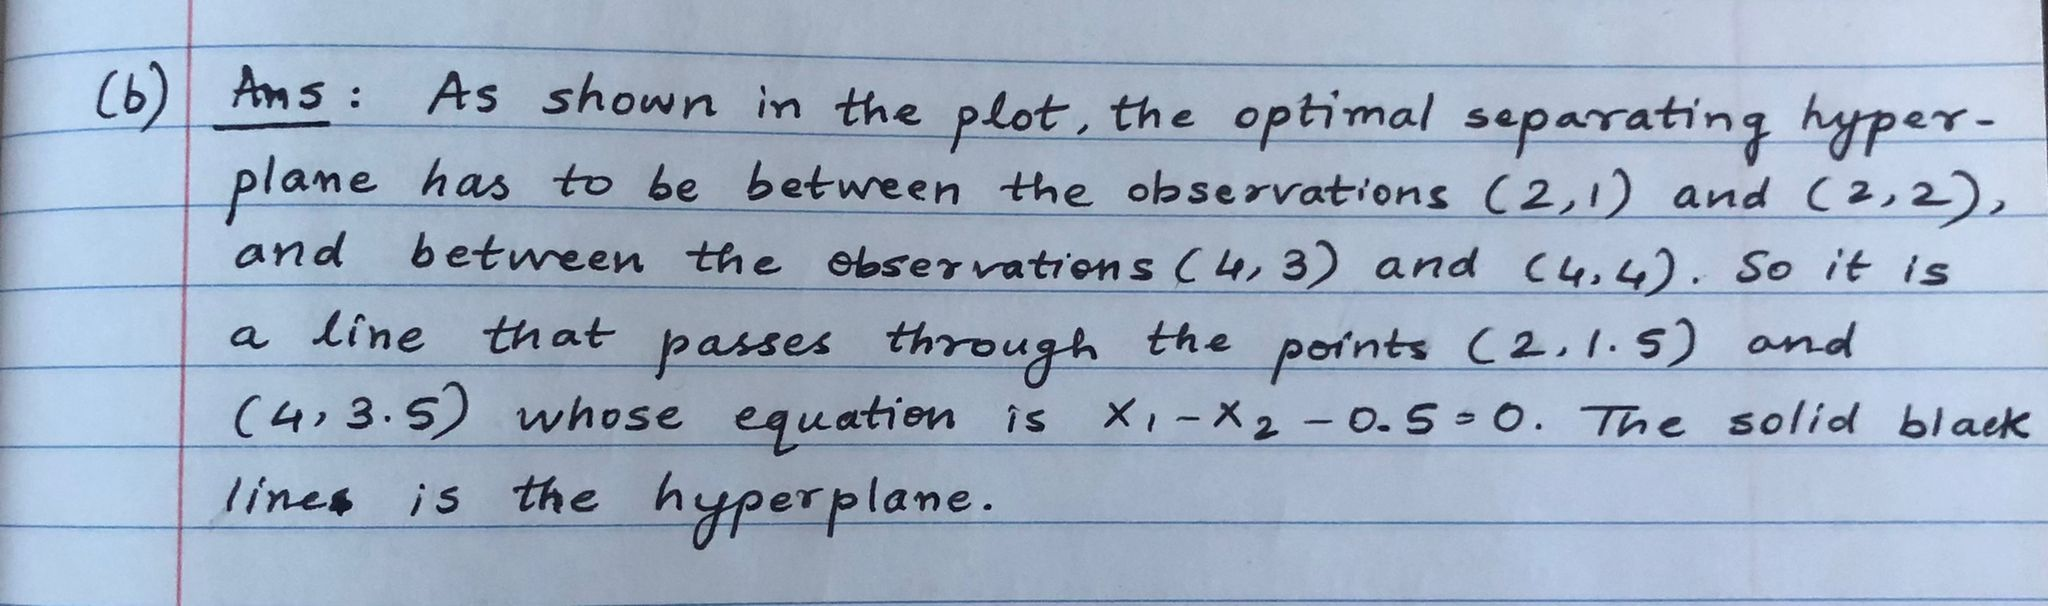

In [3]:
Image('../image/ISLR-9.7.3_b.jpeg')

**(c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if $\beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} > 0$, and classify to Blue otherwise.”** **Provide the values for $\beta_{0}$, $\beta_{1}$, and $\beta_{2}$.**

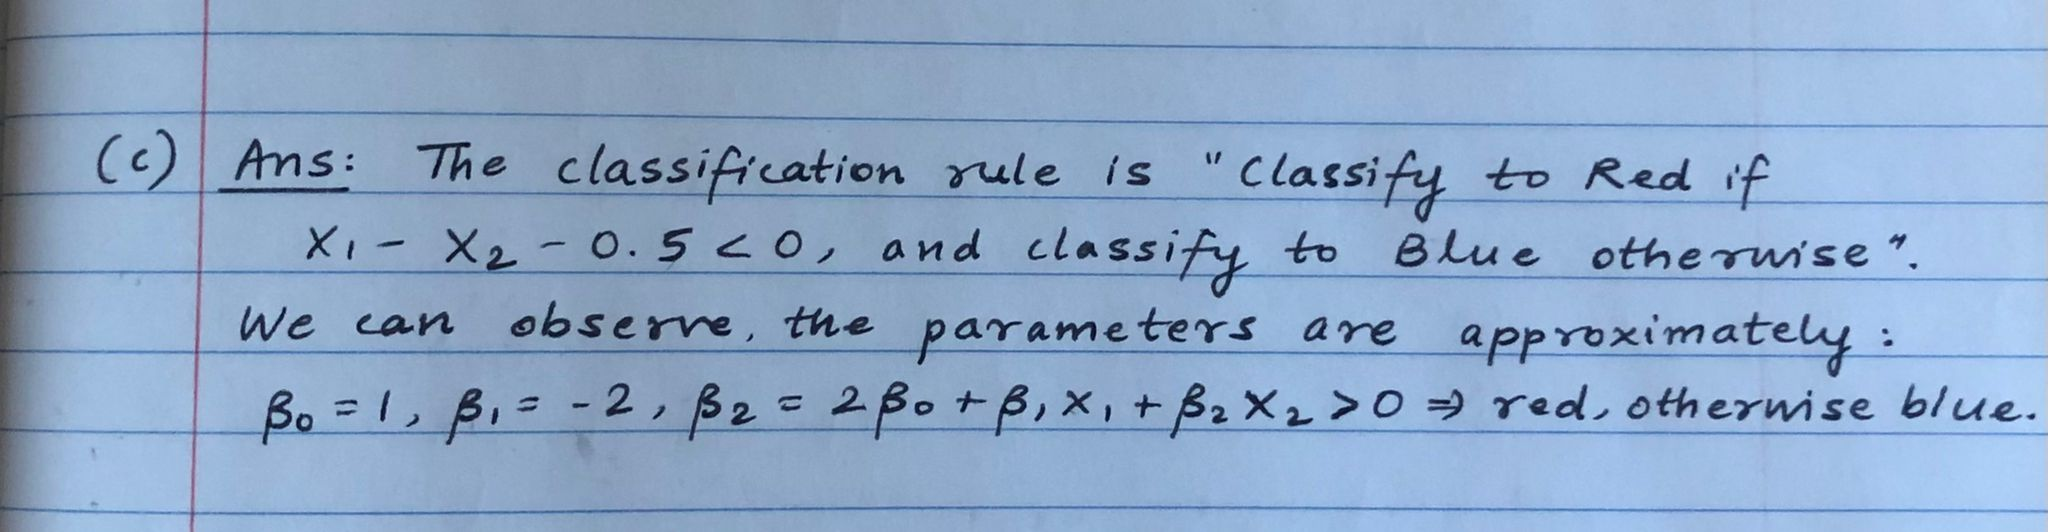

In [4]:
Image('../image/ISLR-9.7.3_c.jpeg')

**(d) On your sketch, indicate the margin for the maximal margin hyperplane.**

**Ans:** *The dash lines in the plot indicate the maximal margin hyperplane. The margin is here equal to 1/4.*

**(e) Indicate the support vectors for the maximal margin classifier**

**Ans:** *The circled observations in the plot i.e. the points (2,1), (2,2), (4,3) and (4,4) are the support vectors for the maximal margin classifier.*

**(f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.**

**Ans:** *The seventh point is far away from the maximal margin hyperplane. By examining the plot, it is clear that if we moved the observation (4,1), we would not change the maximal margin hyperplane as it is not a support vector. If it is on the edge of decision boundary, it will have effects but it does not. Hence it would not affect the maximal margin hyperplane.*

**(g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.**

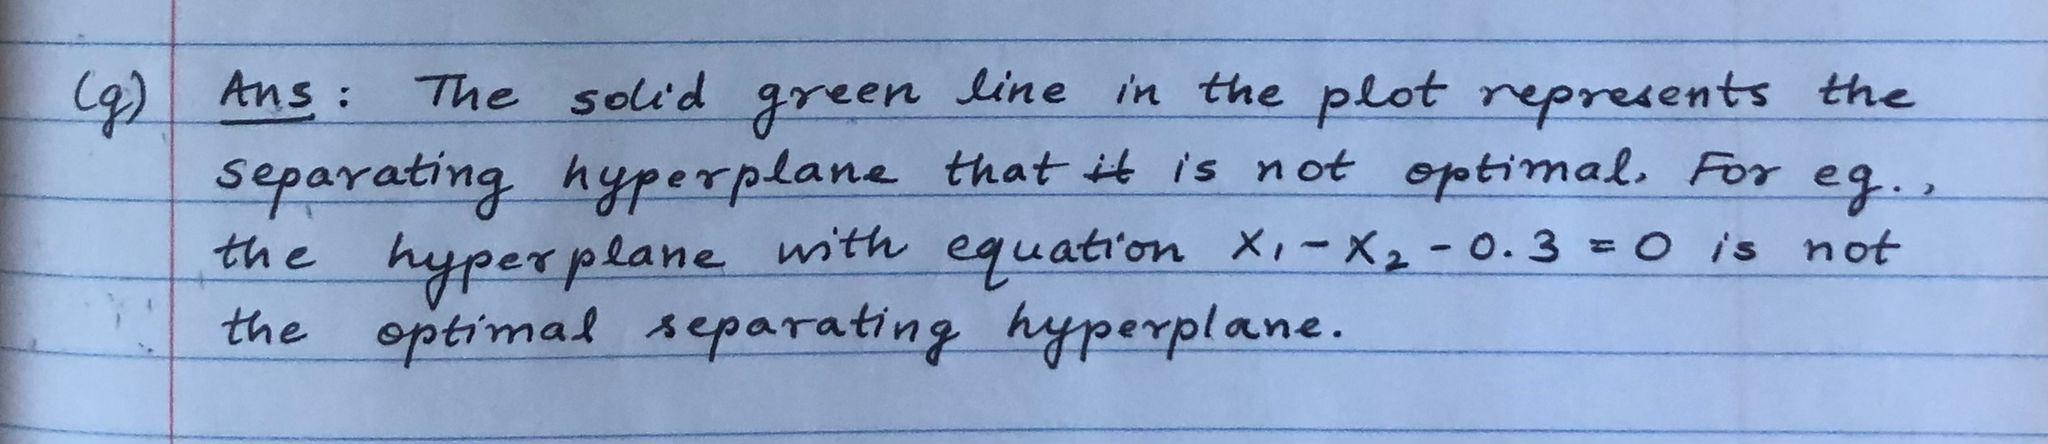

In [5]:
Image('../image/ISLR-9.7.3_g.jpeg')

**(h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.**

**Ans:** *The new red point shaped as a triangle indicates the additional observation in the plot. This makes the data points form an XOR pattern which is not linear-separable by a hyperplane.*